In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PM_980 Signal Classification Project

**Student ID:** 211805018
**Dataset ID:** PM_980

This notebook presents the solution for the PM_980 signal classification task, as part of the Machine Learning Final Project. The project will be executed following the steps outlined in the instructions.

**General Objective:** To classify 9 different operational states (healthy, scratch, etc.) using data from 8 different sensors (sound, accelerometer, gyroscope, temperature) and speed interval information.

The following main sections will be covered in this notebook:
1.  Preparation and Library Imports
2.  Data Exploration and Understanding (including Input-Output Cross-Correlation Map)
3.  Development of the Feature Extraction Function (Time and Frequency Domain Only)
4.  Data Splitting and Preprocessing
5.  Model Training, Selection, and Evaluation (with Stratified 10-Fold CV)
6.  Visualizations (Confusion Matrix, Feature Importance Plots, etc.)
7.  Reporting of Results
---

---
## STAGE 1: PREPARATION

In this initial stage, we will perform the essential setup steps for our project. This includes:
*   Importing the necessary Python libraries.
*   Defining some global constants (e.g., `RANDOM_SEED`) that will be used throughout the project.
*   Loading the PM_980 dataset.
---

### 1.1 Importing Necessary Libraries

In this cell, we import the fundamental Python libraries required for our project.
- `numpy`: For numerical computations and array operations.
- `pandas`: For data manipulation and analysis (especially DataFrame structures).
- `matplotlib.pyplot` and `seaborn`: For data visualization.
- `os`: For interacting with the operating system (e.g., file paths).
- `sklearn` (scikit-learn): For machine learning algorithms, data preprocessing tools, and evaluation metrics.

In [ ]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Scikit-learn Modules (more will be added in later stages)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Visualization Settings
%matplotlib inline
# plt.style.use('seaborn-v0_8-whitegrid') # Using a more modern seaborn style below
sns.set_theme(style="whitegrid") # A modern seaborn theme
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Float display format

print("Necessary libraries imported successfully.")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")
import sklearn # Import sklearn to get its version
print(f"Scikit-learn version: {sklearn.__version__}")

Necessary libraries imported successfully.
NumPy version: 2.0.2
Pandas version: 2.2.2
Seaborn version: 0.13.2
Scikit-learn version: 1.6.1


### 1.2 Global Settings and Constants

In this cell, we define some constant values that will be used throughout the project.
- `RANDOM_SEED`: As specified in the instructions, this will be set to `13` for the data splitting process. This ensures the reproducibility of our experiments.
- `DATASET_DIR`: The directory where the datasets are located. Based on your file structure, this is the `PM980` subfolder.
- `TARGET_COLUMN`: The name of the column containing the class labels (this might become clearer after loading the dataset; for now, we'll make an assumption).
- `SAMPLING_RATE`: The sampling rate of the sensor data, given as 90Hz for the PM_980 dataset.

In [ ]:
# Constant Values
RANDOM_SEED = 13
# Updated DATASET_DIR based on your file structure
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/PM980/" # Datasets are in the PM980 subfolder

# Sampling rate (Hz) - specified for PM_980
SAMPLING_RATE = 90

# Name of the target variable's column (This may change based on your dataset, let's assume 'target' for now)
# Update this name with the actual column name after loading your dataset.
TARGET_COLUMN = 'target' # or 'class_label', 'fault_type', etc.

print(f"Random Seed: {RANDOM_SEED}")
print(f"Dataset Directory: {DATASET_DIR}")
print(f"Sampling Rate: {SAMPLING_RATE} Hz")
print(f"Target Column (Default): {TARGET_COLUMN}")

Random Seed: 13
Dataset Directory: /content/drive/MyDrive/Colab Notebooks/PM980/
Sampling Rate: 90 Hz
Target Column (Default): target


### 1.3 Loading and Combining Multiple Datasets

In this step, we will load the PM_980 dataset. Since the data is distributed across multiple CSV files within the `PM980` subfolder, we need to:
1.  List all CSV files in the specified `DATASET_DIR`.
2.  Iterate through each file.
3.  For each file, extract relevant information such as the class label (e.g., "scratch", "singlecutlong") and potentially other features like speed interval from its filename. The project instructions list 9 classes: `healthy, scratch, notchshort, notchlong, singlecutlong, singlecutshort, twocutlong, twocutshort, warped`. We need to map the filenames to these official class names.
4.  Read the data from each CSV file.
5.  Add new columns to each DataFrame for the extracted class label and any other information derived from the filename.
6.  Concatenate all these individual DataFrames into a single, comprehensive DataFrame (`df_raw`).

**Note:** The logic for extracting information from filenames is based on the observed patterns in your provided examples. You may need to adjust this logic if there are other filename patterns or if the mapping to official class names needs refinement.

In [ ]:
import glob # For finding files matching a pattern
# Ensure pandas and os are imported if this cell is run independently after a kernel restart
import pandas as pd
import os

# List of official class names as per project description
OFFICIAL_CLASSES = [
    "healthy", "scratch", "notchshort", "notchlong",
    "singlecutlong", "singlecutshort", "twocutlong", "twocutshort", "warped"
]

# Helper function to extract information from filename
def extract_info_from_filename(filename_base_no_ext): # Renamed arg for clarity
    """
    Extracts class label, speed information, and returns the original base filename (without extension)
    from the filename.
    Example filenames (after .csv removed):
    40.0_50.0_scracth_indoor_clear_980
    60.0_70.0_singlecutlong_outdoor_noisy_980
    """
    parts = filename_base_no_ext.split('_')
    class_label = "unknown" # Default
    speed_info = "unknown"  # Default

    if len(parts) > 1 and '.' in parts[0] and '.' in parts[1]:
        speed_info = f"{parts[0]}_{parts[1]}"
        class_candidate_index = 2
    elif len(parts) > 0 and '.' in parts[0]:
        speed_info = parts[0]
        class_candidate_index = 1
    else:
        speed_info = "N/A"
        class_candidate_index = 0

    filename_lower = filename_base_no_ext.lower()
    if "scracth" in filename_lower: # Typo
        class_label = "scratch"
    else:
        for official_class in OFFICIAL_CLASSES:
            if official_class.lower() in filename_lower:
                class_label = official_class
                break

    if class_label == "unknown" and len(parts) > class_candidate_index:
        potential_class_from_index = parts[class_candidate_index].lower()
        for official_class in OFFICIAL_CLASSES:
            if official_class.lower() == potential_class_from_index:
                class_label = official_class
                break
        if class_label == "unknown":
             print(f"Warning: Could not map class from part: '{parts[class_candidate_index]}' in '{filename_base_no_ext}'. Defaulting to 'unknown'.")

    # Return the original base filename (without extension) as 'original_filename_id'
    # This is what we will use to group segments.
    return {'class_label': class_label,
            'speed_info': speed_info,
            'original_filename_id': filename_base_no_ext} # Changed key name for clarity

all_dataframes = []
# Ensure DATASET_DIR is defined (from Cell 1.2)
# If running this cell standalone, you might need: DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/PM980/"
csv_files = glob.glob(os.path.join(DATASET_DIR, "*.csv"))

if not csv_files:
    print(f"No CSV files found in directory: {DATASET_DIR}")
    df_raw = pd.DataFrame()
    print("Created an empty DataFrame as no CSV files were found.")
else:
    print(f"Found {len(csv_files)} CSV files. Processing...")
    for filepath in csv_files:
        filename_with_ext = os.path.basename(filepath) # e.g., "40.0_50.0_scracth_indoor_clear_980.csv"
        filename_base_no_ext = filename_with_ext.replace('.csv', '') # e.g., "40.0_50.0_scracth_indoor_clear_980"

        try:
            file_info = extract_info_from_filename(filename_base_no_ext) # Pass filename without extension
            df_temp = pd.read_csv(filepath)

            # Add extracted info as new columns
            df_temp['target'] = file_info['class_label']
            df_temp['speed_interval_filename'] = file_info['speed_info']
            # ****** THIS IS THE CRUCIAL LINE TO ADD/ACTIVATE ******
            df_temp['original_filename_id'] = file_info['original_filename_id'] # Use the key from file_info

            all_dataframes.append(df_temp)
        except Exception as e:
            print(f"Error processing file {filename_with_ext}: {e}")

    if all_dataframes:
        df_raw = pd.concat(all_dataframes, ignore_index=True)
        print("\nAll CSV files have been loaded and combined.")
        print("--- Raw Combined DataFrame (df_raw) ---")
        print("\nFirst 5 rows (df_raw.head()):")
        display(df_raw.head()) # Now should include 'original_filename_id'
        print(f"\nShape of the combined DataFrame (rows, columns): {df_raw.shape}") # Columns should be 13 now
        print("\nData types and non-null counts (df_raw.info()):")
        df_raw.info()
        print("\nDistribution of target classes (df_raw['target'].value_counts()):")
        display(df_raw['target'].value_counts())
        print("\nUnique values in 'speed_interval_filename' (df_raw['speed_interval_filename'].value_counts()):")
        display(df_raw['speed_interval_filename'].value_counts())
        print("\nNumber of unique original filenames (segments):")
        print(df_raw['original_filename_id'].nunique())


        if 'target' in df_raw.columns:
            # TARGET_COLUMN should already be defined from Cell 1.2,
            # but ensure it's 'target' if that's what we are using
            # TARGET_COLUMN = 'target'
            print(f"\nUsing TARGET_COLUMN: '{TARGET_COLUMN}'")
        else:
            print(f"\nWARNING: The '{TARGET_COLUMN}' column was not found in the combined DataFrame.")

    else:
        print("No dataframes were created. df_raw is empty.")
        df_raw = pd.DataFrame()

# This check should only run if df_raw is not empty
if not df_raw.empty:
    unknown_class_count = df_raw[df_raw['target'] == 'unknown'].shape[0]
    if unknown_class_count > 0:
        print(f"\nWARNING: {unknown_class_count} samples have an 'unknown' target class. Please review the `extract_info_from_filename` function and your filenames.")
    else:
        print("\nSuccessfully mapped class labels for all loaded files.")
else:
    print("\ndf_raw is empty, skipping unknown class check.")

Found 480 CSV files. Processing...

All CSV files have been loaded and combined.
--- Raw Combined DataFrame (df_raw) ---

First 5 rows (df_raw.head()):


,Speed,Voice,Acceleration X,Acceleration Y,Acceleration Z,Gyro X,Gyro Y,Gyro Z,Temperature,Speed_Range,target,speed_interval_filename,original_filename_id
0,100.000,1618.000,-2.140,-6.520,4.910,-10.090,28.710,-12.070,27.780,100.0-110.0,healthy,100.0_110.0,100.0_110.0_healthynotchshort_indoor_noisy_980
1,100.000,1502.000,2.080,5.070,16.240,6.860,-25.490,8.880,27.780,100.0-110.0,healthy,100.0_110.0,100.0_110.0_healthynotchshort_indoor_noisy_980
2,100.000,2927.000,2.610,6.320,15.250,6.880,-36.350,13.370,27.790,100.0-110.0,healthy,100.0_110.0,100.0_110.0_healthynotchshort_indoor_noisy_980
3,100.000,0.000,-0.880,2.940,6.970,4.100,-8.230,7.220,27.780,100.0-110.0,healthy,100.0_110.0,100.0_110.0_healthynotchshort_indoor_noisy_980
4,100.000,2342.000,-1.870,-5.460,7.880,-5.510,25.260,-9.700,27.790,100.0-110.0,healthy,100.0_110.0,100.0_110.0_healthynotchshort_indoor_noisy_980



Shape of the combined DataFrame (rows, columns): (206919, 13)

Data types and non-null counts (df_raw.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206919 entries, 0 to 206918
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Speed                    206919 non-null  float64
 1   Voice                    206919 non-null  float64
 2   Acceleration X           206919 non-null  float64
 3   Acceleration Y           206919 non-null  float64
 4   Acceleration Z           206919 non-null  float64
 5   Gyro X                   206919 non-null  float64
 6   Gyro Y                   206919 non-null  float64
 7   Gyro Z                   206919 non-null  float64
 8   Temperature              206919 non-null  float64
 9   Speed_Range              206919 non-null  object 
 10  target                   206919 non-null  object 
 11  speed_interval_filename  206919 non-null  object 
 12  or

,count
target,
healthy,90747
scratch,25537
twocutlong,15073
twocutshort,14957
notchlong,13667
notchshort,13539
singlecutshort,13239
warped,11544
singlecutlong,8616



Unique values in 'speed_interval_filename' (df_raw['speed_interval_filename'].value_counts()):


,count
speed_interval_filename,
50.0_60.0,24570
60.0_70.0,24397
40.0_50.0,24353
70.0_80.0,24105
80.0_90.0,21241
130.0_140.0,18480
90.0_100.0,18104
120.0_130.0,17602
110.0_120.0,17221



Number of unique original filenames (segments):
480

Using TARGET_COLUMN: 'target'

Successfully mapped class labels for all loaded files.


---
**End of Stage 1: Preparation Completed.**

In this stage:
1.  Necessary libraries for the project were successfully imported.
2.  Essential constants (RANDOM_SEED, SAMPLING_RATE, DATASET_DIR, TARGET_COLUMN) were defined.
3.  The PM_980 dataset, comprising multiple CSV files, was successfully loaded, combined, and initial observations were made. The raw combined data is stored in the `df_raw` DataFrame.
---

---
## STAGE 2: DATA EXPLORATION AND UNDERSTANDING

In this stage, we will perform an exploratory data analysis (EDA) on the raw combined dataset (`df_raw`) loaded in Stage 1. The goals of this stage are:
- To gain a better understanding of the dataset's structure and content.
- To check for missing values (re-confirming from `.info()`) and identify potential outliers.
- To examine the distributions of the features.
- To generate the "inputs, output cross-correlation map" as specifically requested in the project instructions.
- To prepare the data for the feature extraction phase.
---

### 2.1 Basic Data Overview

Let's start by re-examining the basic properties of our combined dataset `df_raw`.
We'll look at:
- The first few rows (`.head()`).
- The last few rows (`.tail()`).
- The overall shape (`.shape`).
- Data types and non-null counts (`.info()`) - for quick confirmation.
- Descriptive statistics for numerical features (`.describe()`).
- Descriptive statistics for object/categorical features (`.describe(include='object')`).

In [ ]:
print("--- Basic Data Overview of df_raw ---")

print("\nFirst 5 rows (df_raw.head()):")
display(df_raw.head())

print("\nLast 5 rows (df_raw.tail()):")
display(df_raw.tail())

print(f"\nShape of the DataFrame (rows, columns): {df_raw.shape}")

print("\nData types and non-null counts (df_raw.info()):")
# df_raw.info() # We saw this in detail, can be commented out or run for quick check
# For brevity, let's just print a summary if already checked
if 'df_raw' in locals() and not df_raw.empty:
    print(f"DataFrame has {df_raw.shape[0]} rows and {df_raw.shape[1]} columns.")
    print(f"Number of null values in each column:\n{df_raw.isnull().sum()}")
else:
    print("df_raw is not defined or is empty.")


print("\nDescriptive statistics for numerical features (df_raw.describe()):")
display(df_raw.describe())

print("\nDescriptive statistics for categorical features (df_raw.describe(include='object')):")
# Our object columns are 'target' and 'speed_interval_filename'
# and potentially 'Speed_Range' if it's an object and distinct.
# Let's check data types again to be sure for .describe(include='object')
object_columns = df_raw.select_dtypes(include=['object']).columns
if len(object_columns) > 0:
    display(df_raw[object_columns].describe())
else:
    print("No object type columns found for categorical description.")

--- Basic Data Overview of df_raw ---

First 5 rows (df_raw.head()):


,Speed,Voice,Acceleration X,Acceleration Y,Acceleration Z,Gyro X,Gyro Y,Gyro Z,Temperature,Speed_Range,target,speed_interval_filename,original_filename_id
0,100.000,1618.000,-2.140,-6.520,4.910,-10.090,28.710,-12.070,27.780,100.0-110.0,healthy,100.0_110.0,100.0_110.0_healthynotchshort_indoor_noisy_980
1,100.000,1502.000,2.080,5.070,16.240,6.860,-25.490,8.880,27.780,100.0-110.0,healthy,100.0_110.0,100.0_110.0_healthynotchshort_indoor_noisy_980
2,100.000,2927.000,2.610,6.320,15.250,6.880,-36.350,13.370,27.790,100.0-110.0,healthy,100.0_110.0,100.0_110.0_healthynotchshort_indoor_noisy_980
3,100.000,0.000,-0.880,2.940,6.970,4.100,-8.230,7.220,27.780,100.0-110.0,healthy,100.0_110.0,100.0_110.0_healthynotchshort_indoor_noisy_980
4,100.000,2342.000,-1.870,-5.460,7.880,-5.510,25.260,-9.700,27.790,100.0-110.0,healthy,100.0_110.0,100.0_110.0_healthynotchshort_indoor_noisy_980



Last 5 rows (df_raw.tail()):


,Speed,Voice,Acceleration X,Acceleration Y,Acceleration Z,Gyro X,Gyro Y,Gyro Z,Temperature,Speed_Range,target,speed_interval_filename,original_filename_id
206914,90.000,1849.000,-2.170,-0.630,10.110,-0.260,12.200,-2.560,27.810,90.0-100.0,twocutshort,90.0_100.0,90.0_100.0_twocutshort_indoor_noisy_980
206915,90.000,822.000,3.950,3.500,17.490,1.710,-21.980,6.140,27.840,90.0-100.0,twocutshort,90.0_100.0,90.0_100.0_twocutshort_indoor_noisy_980
206916,90.000,1567.000,-2.870,-2.470,3.130,-0.150,16.170,-3.210,27.820,90.0-100.0,twocutshort,90.0_100.0,90.0_100.0_twocutshort_indoor_noisy_980
206917,90.000,576.000,-1.270,-4.990,6.170,-5.690,23.120,-7.730,27.830,90.0-100.0,twocutshort,90.0_100.0,90.0_100.0_twocutshort_indoor_noisy_980
206918,90.000,1774.000,-2.160,-2.550,9.210,-0.560,23.120,-5.650,27.830,90.0-100.0,twocutshort,90.0_100.0,90.0_100.0_twocutshort_indoor_noisy_980



Shape of the DataFrame (rows, columns): (206919, 13)

Data types and non-null counts (df_raw.info()):
DataFrame has 206919 rows and 13 columns.
Number of null values in each column:
Speed                      0
Voice                      0
Acceleration X             0
Acceleration Y             0
Acceleration Z             0
Gyro X                     0
Gyro Y                     0
Gyro Z                     0
Temperature                0
Speed_Range                0
target                     0
speed_interval_filename    0
original_filename_id       0
dtype: int64

Descriptive statistics for numerical features (df_raw.describe()):


,Speed,Voice,Acceleration X,Acceleration Y,Acceleration Z,Gyro X,Gyro Y,Gyro Z,Temperature
count,206919.000,206919.000,206919.000,206919.000,206919.000,206919.000,206919.000,206919.000,206919.000
mean,81.075,1505.641,0.073,-0.112,9.621,-0.134,-0.118,0.063,24.590
std,28.783,859.624,5.649,10.211,8.033,35.227,35.583,18.858,4.680
min,40.000,0.000,-73.840,-79.100,-78.540,-495.500,-440.720,-352.100,15.240
25%,60.000,991.000,-0.870,-1.220,9.110,-1.890,-2.680,-1.650,18.160
50%,80.000,1456.000,-0.030,0.000,9.800,-0.040,-0.010,0.020,27.440
75%,110.000,2028.000,0.730,1.230,10.430,1.800,2.770,1.780,27.890
max,130.000,4095.000,80.190,78.210,78.480,504.570,499.310,423.320,28.750



Descriptive statistics for categorical features (df_raw.describe(include='object')):


,Speed_Range,target,speed_interval_filename,original_filename_id
count,206919,206919,206919,206919
unique,10,9,10,480
top,50.0-60.0,healthy,50.0_60.0,130.0_140.0_twocutlong_indoor_clear_980
freq,24570,90747,24570,874


### 2.2 Target Variable Encoding

To calculate the cross-correlation between input features and the output (target variable), the target variable needs to be in a numerical format. Currently, our `target` column is of object type (strings). We will use Label Encoding to convert these string labels into numerical representations.

We will also store the mapping between the original labels and the encoded numbers for future reference (e.g., when interpreting results or the confusion matrix).

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the target column before encoding, if needed for other direct string comparisons later
# df_raw['target_original_string'] = df_raw['target'] # Optional

le = LabelEncoder()
df_raw['target_encoded'] = le.fit_transform(df_raw['target'])

# Store the mapping
target_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Target variable has been label encoded.")
print("Mapping of original labels to encoded numbers:")
for label, encoded_value in target_label_mapping.items():
    print(f"- {label}: {encoded_value}")

print("\nFirst 5 rows with 'target' and 'target_encoded':")
display(df_raw[['target', 'target_encoded']].head())

print("\nValue counts of 'target_encoded':")
display(df_raw['target_encoded'].value_counts().sort_index())

Target variable has been label encoded.
Mapping of original labels to encoded numbers:
- healthy: 0
- notchlong: 1
- notchshort: 2
- scratch: 3
- singlecutlong: 4
- singlecutshort: 5
- twocutlong: 6
- twocutshort: 7
- warped: 8

First 5 rows with 'target' and 'target_encoded':


,target,target_encoded
0,healthy,0
1,healthy,0
2,healthy,0
3,healthy,0
4,healthy,0



Value counts of 'target_encoded':


,count
target_encoded,
0,90747
1,13667
2,13539
3,25537
4,8616
5,13239
6,15073
7,14957
8,11544


### 2.3 Input-Output Cross-Correlation Map

As per the project instructions, we need to show an "inputs, output cross-correlation map". This involves calculating the correlation between each input feature and the (encoded) target variable. We will then visualize these correlations, typically using a heatmap or a bar plot.

We will select only the numerical input features and our `target_encoded` column for this calculation.
The `Speed_Range` and `speed_interval_filename` are categorical; if we want to include speed information, we might need to encode it numerically first or use `Speed` column directly if it represents the interval adequately. For now, let's focus on the raw numerical sensor inputs and the `Speed` column.

Correlation of input features with 'target_encoded':
Acceleration X    0.034
Temperature       0.034
Speed             0.031
Voice             0.019
Gyro Z           -0.001
Gyro X           -0.001
Gyro Y           -0.002
Acceleration Y   -0.007
Acceleration Z   -0.015
Name: target_encoded, dtype: float64


<ipython-input-23-46680f60e072>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="coolwarm")


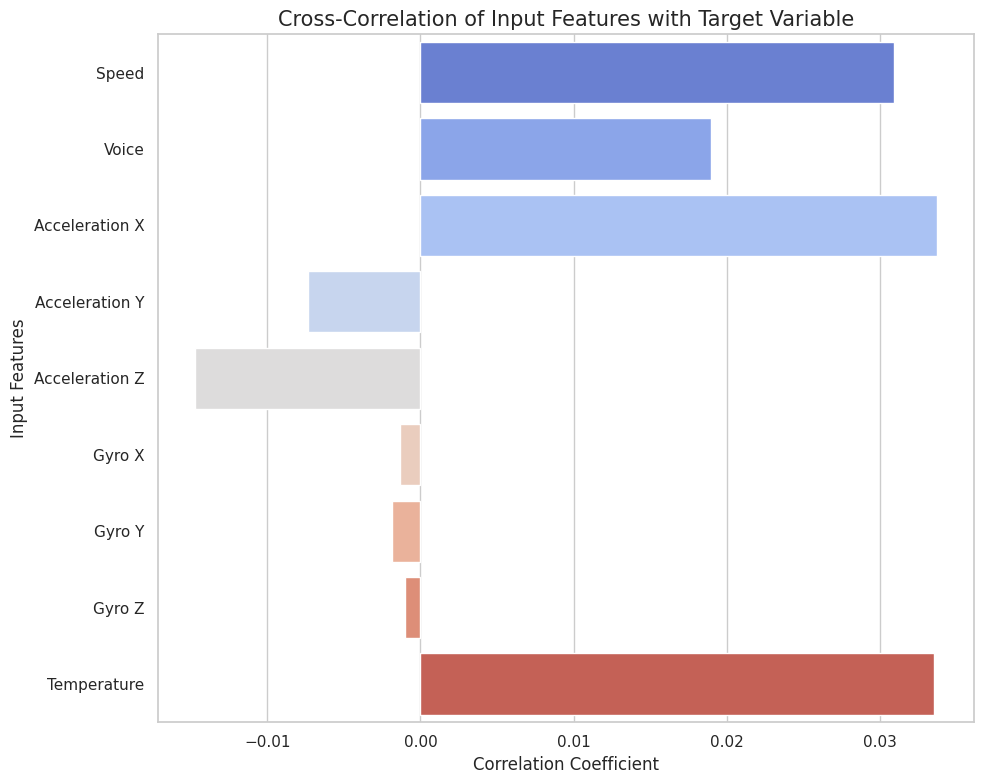

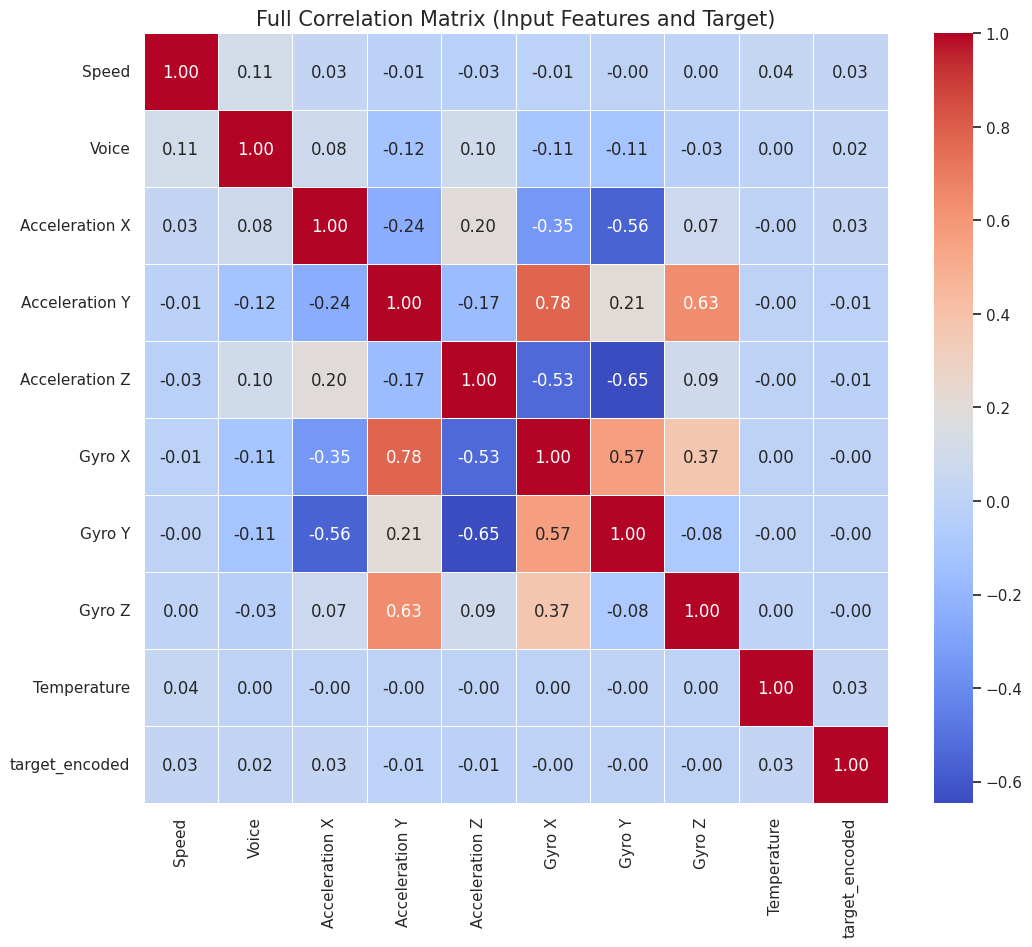

In [ ]:
# Select numerical features and the encoded target
numerical_features = df_raw.select_dtypes(include=np.number).columns.tolist()

# Remove target_encoded from the list of features if it's there, as it's our target
if 'target_encoded' in numerical_features:
    numerical_features.remove('target_encoded')

# Also, if we have other non-sensor or non-input numerical columns, we might want to exclude them.
# For example, if there was an 'ID' column. Here, all numerical columns seem to be inputs.
# Let's specifically list the input features we are interested in for correlation with target.
# These are the 8 sensor readings + Speed.
input_features_for_correlation = ['Speed', 'Voice',
                                  'Acceleration X', 'Acceleration Y', 'Acceleration Z',
                                  'Gyro X', 'Gyro Y', 'Gyro Z',
                                  'Temperature']

# Ensure all selected features are indeed in the DataFrame
valid_input_features = [col for col in input_features_for_correlation if col in df_raw.columns]

# Create a temporary DataFrame with only these input features and the encoded target
df_for_correlation = df_raw[valid_input_features + ['target_encoded']].copy()

# Calculate the correlation matrix
correlation_matrix = df_for_correlation.corr()

# Get the correlations of each feature with the target variable
# This will be the last row or column of the correlation_matrix, depending on how you access it.
target_correlations = correlation_matrix['target_encoded'].drop('target_encoded') # Drop self-correlation

print("Correlation of input features with 'target_encoded':")
print(target_correlations.sort_values(ascending=False))

# Visualize these correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="coolwarm")
plt.title('Cross-Correlation of Input Features with Target Variable', fontsize=15)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Input Features', fontsize=12)
plt.tight_layout()
plt.show()

# Optional: Display the full correlation heatmap for selected features + target
# This can give a broader view but the bar plot above is more direct for input-output.
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Full Correlation Matrix (Input Features and Target)', fontsize=15)
plt.show()

### 2.4 Feature Distribution Visualization

Let's visualize the distributions of our numerical input features. This can help us understand their spread, skewness, and modality. We'll use histograms and kernel density plots (KDE) for this purpose.
We will focus on the primary input features: `Speed`, `Voice`, `Acceleration X/Y/Z`, `Gyro X/Y/Z`, and `Temperature`.

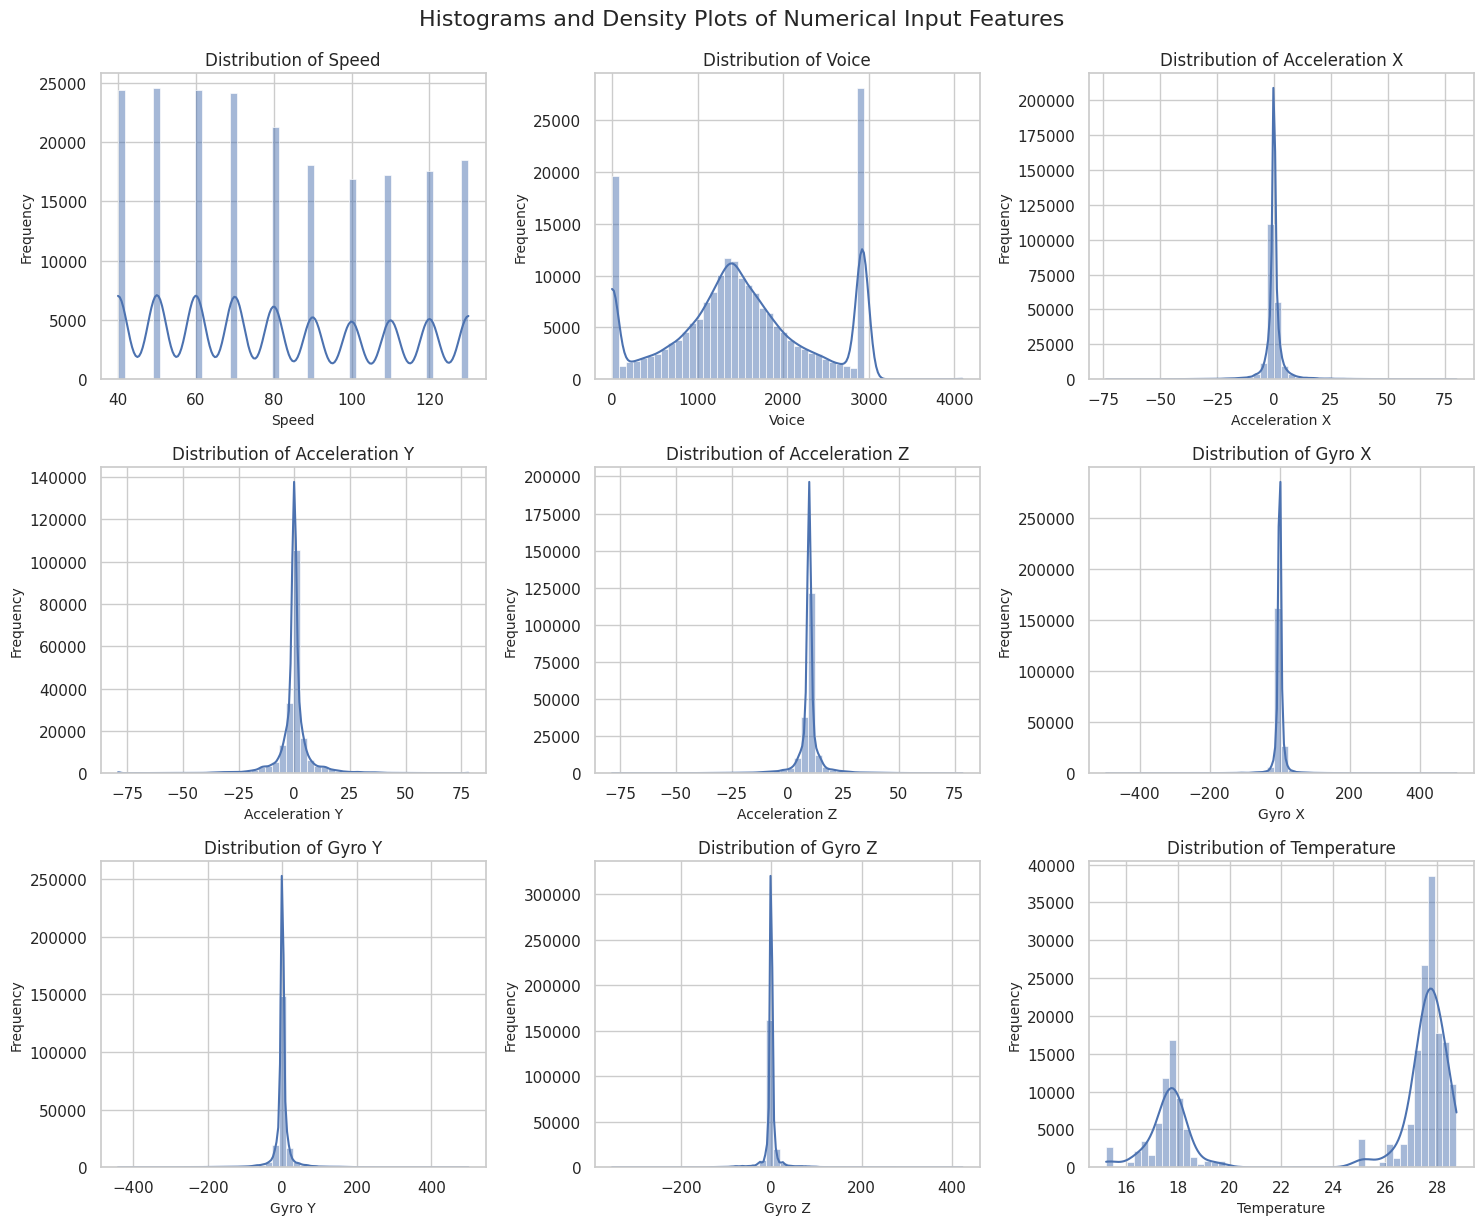

In [ ]:
# Select the numerical features we want to plot
# We already have 'input_features_for_correlation' which is a good list
# Alternatively, select all numerical, excluding target_encoded
plot_features = [col for col in df_raw.select_dtypes(include=np.number).columns if col != 'target_encoded']

# Determine the number of rows and columns for the subplot grid
n_features = len(plot_features)
n_cols = 3 # Let's aim for 3 plots per row
n_rows = (n_features - 1) // n_cols + 1

plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figure size as needed

for i, feature in enumerate(plot_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_raw[feature], kde=True, bins=50) # Plot histogram with KDE
    plt.title(f'Distribution of {feature}', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.suptitle('Histograms and Density Plots of Numerical Input Features', fontsize=16, y=1.02) # Super title for all subplots
plt.show()

### 2.5 Outlier Detection using Box Plots

Box plots are useful for visualizing the distribution of data and identifying potential outliers. We will generate box plots for the same set of numerical input features.
Outliers are data points that significantly differ from other observations. They can be seen as points lying outside the "whiskers" of the box plot.

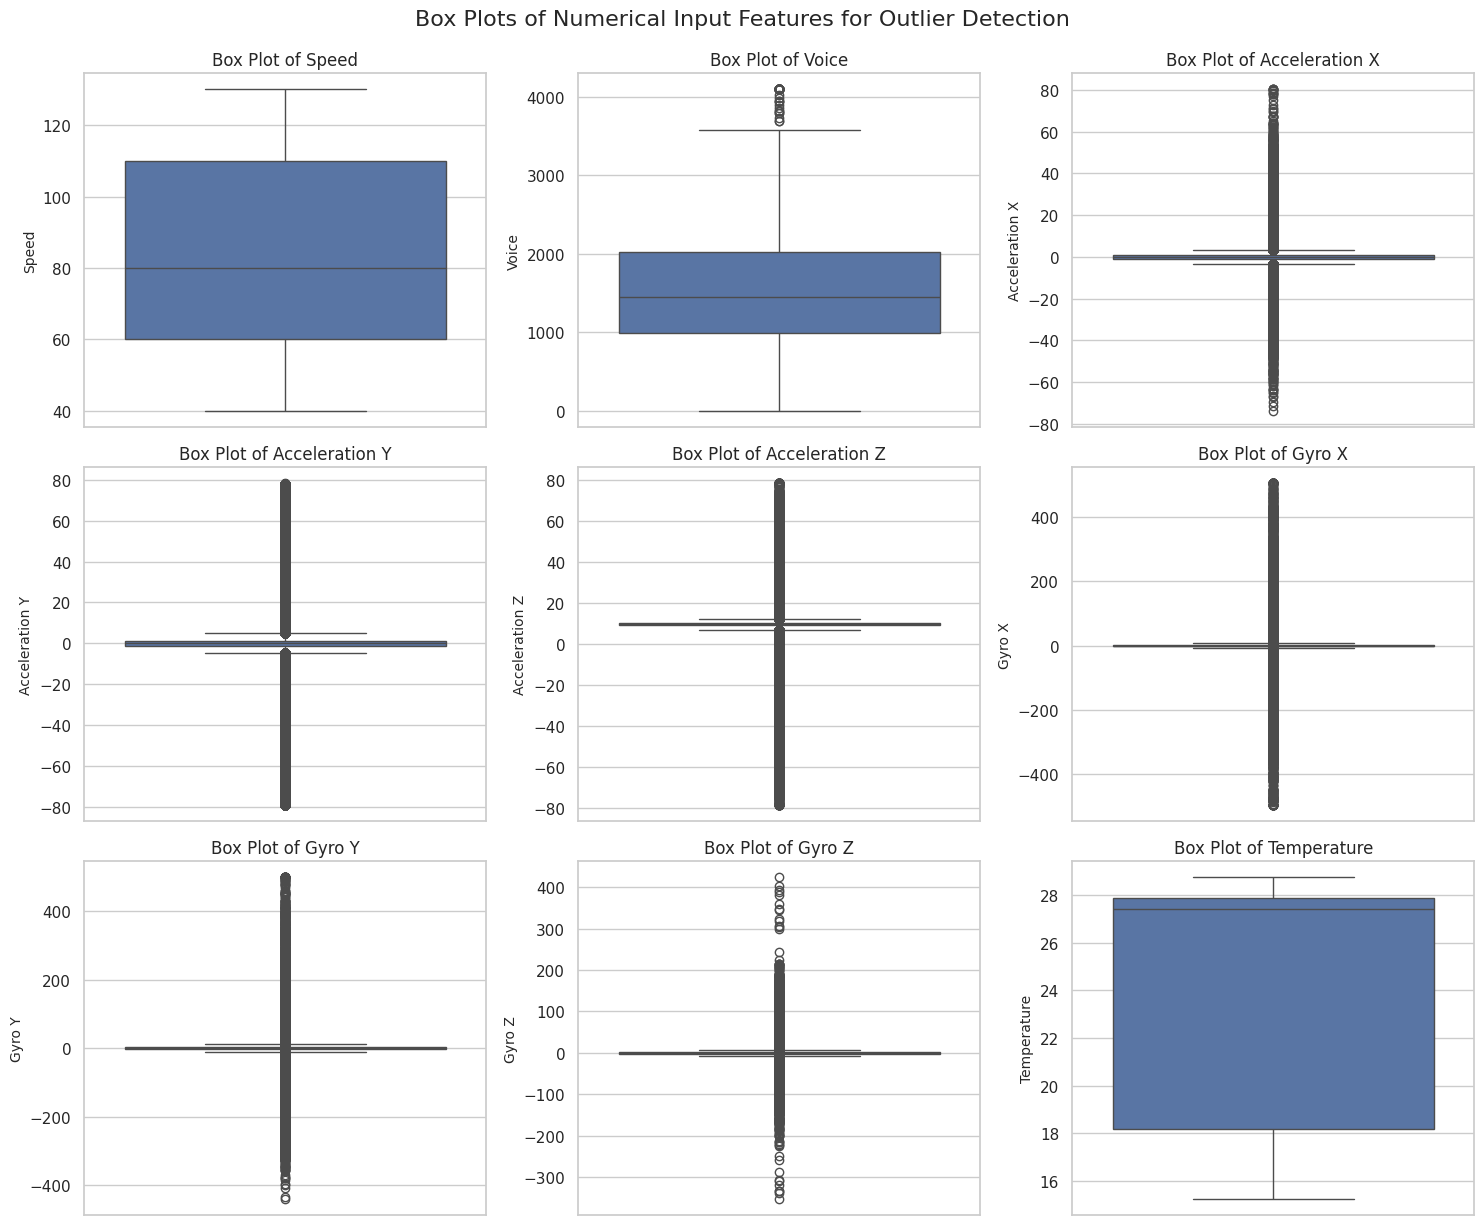

In [ ]:
# Using the same 'plot_features' list from the previous cell

plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figure size as needed

for i, feature in enumerate(plot_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df_raw[feature]) # Create a box plot for each feature
    plt.title(f'Box Plot of {feature}', fontsize=12)
    plt.ylabel(feature, fontsize=10)

plt.tight_layout()
plt.suptitle('Box Plots of Numerical Input Features for Outlier Detection', fontsize=16, y=1.02) # Super title
plt.show()

---
**End of Stage 2: Data Exploration and Understanding Completed.**

In this stage, we conducted a thorough Exploratory Data Analysis (EDA) of the `df_raw` dataset:

1.  **Basic Overview:** We re-confirmed the dataset's shape (206,919 rows, 12 columns), data types, and the crucial finding of **no missing values** across all features.
2.  **Descriptive Statistics:**
    *   Numerical features showed varying scales, means, and standard deviations, highlighting the need for feature scaling later.
    *   Categorical features (`target`, `Speed_Range`, `speed_interval_filename`) were examined, revealing 9 unique target classes and 10 unique speed intervals. A notable class imbalance was observed in the `target` variable, with "healthy" being the most frequent class.
3.  **Target Encoding:** The categorical `target` variable was successfully label encoded into a numerical `target_encoded` column, which is essential for correlation analysis and model training. A mapping of original labels to encoded numbers was stored.
4.  **Input-Output Cross-Correlation:**
    *   The Pearson correlation coefficients between raw numerical input features and the `target_encoded` variable were generally very low. This suggests that the raw signals might not have strong direct linear relationships with the target classes, underscoring the importance of the feature extraction step.
    *   The full correlation matrix also revealed some inter-correlations between input features (e.g., between different gyroscope and accelerometer axes).
5.  **Feature Distributions:**
    *   Histograms and density plots showed diverse distributions for numerical features. `Speed` and `Temperature` exhibited multimodal distributions, while `Voice` was right-skewed. Accelerometer and gyroscope readings were mostly centered around zero but with long tails (leptokurtic).
6.  **Outlier Visualization:**
    *   Box plots confirmed the presence of numerous potential outliers in `Voice`, `Acceleration X/Y/Z`, and `Gyro X/Y/Z` features. `Temperature` also showed some outliers on the lower end. These outliers will need consideration during feature engineering and possibly preprocessing.

**Key Takeaways from EDA:**
*   The dataset is clean in terms of missing values.
*   Raw features have varying scales and distributions, with significant outliers in many sensor readings.
*   The direct linear correlation of raw features with the target is weak, emphasizing the necessity of deriving more informative time and frequency domain features as mandated by the project instructions.
*   Class imbalance in the target variable is an important factor to consider for model training and evaluation.
---

---
## STAGE 3: FEATURE EXTRACTION

This is a critical stage where we will derive meaningful features from the raw sensor signals. With the `original_filename_id` column, we can now treat the data from each original CSV file as a distinct signal segment. We will extract features from these segments.

**As per the project instructions:**
- We must **only use time domain and frequency domain features**.
- Time-frequency analysis methods like STFT, Wavelet Transform, or MFCC are **not allowed**.
- We need to implement a feature extraction function and save the transformed dataset.

**Libraries for Signal Processing:**
We will primarily use `numpy` for calculations and `scipy.fft` for Fast Fourier Transform, and `scipy.stats` for some statistical features.

### 3.1 Define Feature Extraction Helper Functions

First, let's define a set of functions to calculate various time-domain and frequency-domain features from a 1D array (a single sensor signal for a segment).

In [ ]:
from scipy.stats import skew, kurtosis, entropy # Ensure these are imported
import numpy as np # Ensure numpy is imported
import pandas as pd # Ensure pandas is imported for pd.value_counts

# SAMPLING_RATE was defined in Cell 1.2 (e.g., 90 Hz)

def calculate_time_domain_features(series):
    """Calculates time-domain features for a given pandas Series."""
    features = {}
    features['mean'] = series.mean()
    features['std'] = series.std()
    # Calculate MAD manually as Series.mad() is deprecated
    if not series.empty: # Ensure series is not empty before calculating mean
        features['mad'] = (series - series.mean()).abs().mean()
    else:
        features['mad'] = np.nan # or 0, or handle as error

    features['median'] = series.median()
    features['min'] = series.min()
    features['max'] = series.max()
    features['range'] = series.max() - series.min()
    features['iqr'] = series.quantile(0.75) - series.quantile(0.25)
    features['skewness'] = skew(series)
    features['kurtosis'] = kurtosis(series)
    features['rms'] = np.sqrt(np.mean(series**2))
    features['zcr'] = ((series.iloc[:-1] * series.iloc[1:].values) < 0).sum()
    features['mac'] = np.mean(np.abs(np.diff(series)))
    # features['shannon_entropy'] = entropy(pd.value_counts(series, normalize=True)) # Needs discrete or binned data

    return features

def calculate_frequency_domain_features(series, sampling_rate):
    """Calculates frequency-domain features for a given pandas Series using FFT."""
    features = {}
    N = len(series)
    if N <= 1: # Cannot perform FFT on a very short series
        # Return NaNs or default values for all frequency features
        freq_feature_names = ['spectral_centroid', 'spectral_spread', 'spectral_skewness',
                              'spectral_kurtosis', 'spectral_rolloff', 'dominant_freq', 'dominant_freq_magnitude']
        # Add more expected freq feature names if you define more below
        for name in freq_feature_names:
            features[name] = np.nan
        return features

    # Apply FFT
    yf = fft(series.values)
    xf = fftfreq(N, 1 / sampling_rate) # Frequencies

    # Keep only positive frequencies (and their magnitudes)
    # For real input, the positive and negative frequency components are symmetric.
    positive_freq_indices = np.where(xf >= 0)[0]
    xf_positive = xf[positive_freq_indices]
    yf_magnitude_positive = np.abs(yf[positive_freq_indices]) / N # Normalize magnitude

    if len(xf_positive) == 0 or np.sum(yf_magnitude_positive) == 0: # Avoid division by zero if all magnitudes are zero
        freq_feature_names = ['spectral_centroid', 'spectral_spread', 'spectral_skewness',
                              'spectral_kurtosis', 'spectral_rolloff', 'dominant_freq', 'dominant_freq_magnitude']
        for name in freq_feature_names:
            features[name] = np.nan
        return features

    # Spectral Centroid (brightness of spectrum)
    features['spectral_centroid'] = np.sum(xf_positive * yf_magnitude_positive) / np.sum(yf_magnitude_positive)

    # Spectral Spread (bandwidth of spectrum)
    features['spectral_spread'] = np.sqrt(np.sum(((xf_positive - features['spectral_centroid'])**2) * yf_magnitude_positive) / np.sum(yf_magnitude_positive))

    # Spectral Skewness and Kurtosis (shape of the spectrum)
    # For these, we can treat magnitudes at different frequencies as a distribution
    # Need to handle cases where spectral_spread is zero to avoid division by zero
    if features['spectral_spread'] > 1e-6: # Check if spread is not effectively zero
        spec_skew_val = np.sum(((xf_positive - features['spectral_centroid'])**3) * yf_magnitude_positive) / (np.sum(yf_magnitude_positive) * (features['spectral_spread']**3))
        spec_kurt_val = np.sum(((xf_positive - features['spectral_centroid'])**4) * yf_magnitude_positive) / (np.sum(yf_magnitude_positive) * (features['spectral_spread']**4)) - 3 # Subtract 3 for excess kurtosis
    else:
        spec_skew_val = 0
        spec_kurt_val = 0 # or some other default, like -3 if normal is 0 after subtraction
    features['spectral_skewness'] = spec_skew_val
    features['spectral_kurtosis'] = spec_kurt_val


    # Spectral Rolloff (frequency below which a certain percentage of total spectral energy lies, e.g., 85%)
    cumulative_energy = np.cumsum(yf_magnitude_positive)
    total_energy = np.sum(yf_magnitude_positive)
    rolloff_threshold = 0.85 * total_energy
    try:
        rolloff_index = np.where(cumulative_energy >= rolloff_threshold)[0][0]
        features['spectral_rolloff'] = xf_positive[rolloff_index]
    except IndexError: # In case all energy is concentrated, or threshold not met
        features['spectral_rolloff'] = xf_positive[-1] if len(xf_positive) > 0 else np.nan


    # Dominant Frequency and its Magnitude
    if len(yf_magnitude_positive) > 0:
        dominant_freq_index = np.argmax(yf_magnitude_positive[1:]) + 1 # Exclude DC component (0 Hz) if desired for dominant freq
        if dominant_freq_index < len(xf_positive):
            features['dominant_freq'] = xf_positive[dominant_freq_index]
            features['dominant_freq_magnitude'] = yf_magnitude_positive[dominant_freq_index]
        else: # Fallback if index is out of bounds (e.g. if only DC component exists)
            features['dominant_freq'] = 0
            features['dominant_freq_magnitude'] = yf_magnitude_positive[0] if len(yf_magnitude_positive)>0 else 0
    else:
        features['dominant_freq'] = np.nan
        features['dominant_freq_magnitude'] = np.nan

    # Add more frequency features: spectral flatness, band energies, etc.
    # Example: Energy in specific bands (e.g., 0-10 Hz, 10-20 Hz, etc.)
    # Define bands: bands = [(0, 10), (10, 20), (20, SAMPLING_RATE/2)]
    # for i, (low_freq, high_freq) in enumerate(bands):
    #    band_indices = np.where((xf_positive >= low_freq) & (xf_positive < high_freq))[0]
    #    features[f'energy_band_{i+1}'] = np.sum(yf_magnitude_positive[band_indices]**2)

    return features

print("Helper functions for feature extraction defined.")
print(f"Using SAMPLING_RATE: {SAMPLING_RATE} Hz for frequency domain features.")

Helper functions for feature extraction defined.
Using SAMPLING_RATE: 90 Hz for frequency domain features.


### 3.2 Apply Feature Extraction to Segments

Now we will iterate through each unique segment (identified by `original_filename_id`) in `df_raw`. For each segment:
1.  We will select the relevant sensor data columns.
2.  For each sensor signal within that segment, we'll apply our `calculate_time_domain_features` and `calculate_frequency_domain_features` functions.
3.  The extracted features will be collected, and a new DataFrame (`df_features`) will be constructed where each row represents one segment (i.e., one original CSV file) and columns are the extracted features.
4.  We also need to carry over the `target` (or `target_encoded`) and `speed_interval_filename` (or `Speed_Range`) associated with each segment. Since all rows within a segment have the same target and speed info, we can just take the first one.

This can be a computationally intensive step depending on the number of segments and the length of each segment.

In [ ]:
# Identify the sensor columns from which we want to extract features
# Exclude 'target_encoded' if it was accidentally included in numerical_features
# Also exclude 'original_filename_id' itself from feature processing
# The `input_features_for_correlation` list from Cell 2.3 is a good starting point for sensor columns.
sensor_columns = ['Speed', 'Voice',
                  'Acceleration X', 'Acceleration Y', 'Acceleration Z',
                  'Gyro X', 'Gyro Y', 'Gyro Z',
                  'Temperature']

# Verify these columns exist in df_raw
actual_sensor_columns = [col for col in sensor_columns if col in df_raw.columns]
if len(actual_sensor_columns) != len(sensor_columns):
    print("Warning: Not all specified sensor_columns were found in df_raw. Using available ones.")
    print(f"Using columns: {actual_sensor_columns}")
sensor_columns = actual_sensor_columns


extracted_features_list = []
grouped_segments = df_raw.groupby('original_filename_id')

print(f"Processing {len(grouped_segments)} segments...")
segment_count = 0

for segment_id, segment_df in grouped_segments:
    segment_count += 1
    if segment_count % 50 == 0: # Print progress every 50 segments
        print(f"Processing segment {segment_count}/{len(grouped_segments)}: {segment_id}")

    all_segment_features = {} # To store all features for this current segment

    # Get target and speed info for this segment (all rows in segment_df should have the same)
    # We also need the original target string for stratification later if we use the new df_features
    all_segment_features['original_filename_id'] = segment_id
    all_segment_features['target'] = segment_df['target'].iloc[0]
    all_segment_features['target_encoded'] = segment_df['target_encoded'].iloc[0]
    all_segment_features['speed_interval_filename'] = segment_df['speed_interval_filename'].iloc[0]
    # If 'Speed_Range' is preferred or different, add it too:
    # all_segment_features['Speed_Range'] = segment_df['Speed_Range'].iloc[0]


    for sensor_col in sensor_columns:
        signal_series = segment_df[sensor_col]

        # Time domain features
        time_features = calculate_time_domain_features(signal_series)
        for feature_name, value in time_features.items():
            all_segment_features[f'{sensor_col}_time_{feature_name}'] = value

        # Frequency domain features
        # For Temperature, frequency features might not be very meaningful if it changes slowly.
        # For Speed, if it's constant or step-wise within a segment, freq features might also be less informative.
        # But we'll calculate them for all specified sensor_columns for now.
        freq_features = calculate_frequency_domain_features(signal_series, SAMPLING_RATE)
        for feature_name, value in freq_features.items():
            all_segment_features[f'{sensor_col}_freq_{feature_name}'] = value

    extracted_features_list.append(all_segment_features)

# Create the new DataFrame from the list of feature dictionaries
df_features = pd.DataFrame(extracted_features_list)

print(f"\nFeature extraction completed for all {len(grouped_segments)} segments.")
print("--- New Features DataFrame (df_features) ---")
print("\nFirst 5 rows (df_features.head()):")
display(df_features.head())
print(f"\nShape of the features DataFrame (rows, columns): {df_features.shape}") # Rows should be 480
print("\nData types and non-null counts (df_features.info()):")
df_features.info()

# Check for any NaN values created during feature extraction
nan_counts_in_features = df_features.isnull().sum()
nan_columns = nan_counts_in_features[nan_counts_in_features > 0]
if not nan_columns.empty:
    print("\nColumns with NaN values and their counts:")
    print(nan_columns)
    print("NaNs might occur if a segment was too short for FFT or if std was zero for some calculations.")
    # Consider an imputation strategy if NaNs are present and significant.
    # For now, we will just note them. Common strategy: fill with mean/median or 0.
else:
    print("\nNo NaN values found in the new features DataFrame.")

Processing 480 segments...


<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-inp

Processing segment 50/480: 110.0_120.0_healthynotchlong_indoor_noisy_980


<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-inp

Processing segment 100/480: 120.0_130.0_healthynotchshort_indoor_clear_980


<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-inp

Processing segment 150/480: 130.0_140.0_healthynotchshort_outdoor_noisy_980


<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-inp

Processing segment 200/480: 40.0_50.0_healthyscracth_indoor_noisy_980


<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-inp

Processing segment 250/480: 50.0_60.0_healthysinglecutlong_indoor_clear_980


<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-inp

Processing segment 300/480: 60.0_70.0_healthysinglecutlong_outdoor_noisy_980


<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-inp

Processing segment 350/480: 70.0_80.0_healthysinglecutshort_indoor_noisy_980


<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-inp

Processing segment 400/480: 80.0_90.0_healthytwocutlong_indoor_clear_980


<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-inp

Processing segment 450/480: 90.0_100.0_healthytwocutlong_outdoor_noisy_980


<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-input-30-3164754e102d>:23: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['skewness'] = skew(series)
<ipython-input-30-3164754e102d>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features['kurtosis'] = kurtosis(series)
<ipython-inp


Feature extraction completed for all 480 segments.
--- New Features DataFrame (df_features) ---

First 5 rows (df_features.head()):


,original_filename_id,target,target_encoded,speed_interval_filename,Speed_time_mean,Speed_time_std,Speed_time_mad,Speed_time_median,Speed_time_min,Speed_time_max,Speed_time_range,Speed_time_iqr,Speed_time_skewness,Speed_time_kurtosis,Speed_time_rms,Speed_time_zcr,Speed_time_mac,Speed_freq_spectral_centroid,Speed_freq_spectral_spread,Speed_freq_spectral_skewness,Speed_freq_spectral_kurtosis,Speed_freq_spectral_rolloff,Speed_freq_dominant_freq,Speed_freq_dominant_freq_magnitude,Voice_time_mean,Voice_time_std,Voice_time_mad,Voice_time_median,Voice_time_min,Voice_time_max,Voice_time_range,Voice_time_iqr,Voice_time_skewness,Voice_time_kurtosis,Voice_time_rms,Voice_time_zcr,Voice_time_mac,Voice_freq_spectral_centroid,Voice_freq_spectral_spread,Voice_freq_spectral_skewness,Voice_freq_spectral_kurtosis,Voice_freq_spectral_rolloff,Voice_freq_dominant_freq,Voice_freq_dominant_freq_magnitude,Acceleration X_time_mean,Acceleration X_time_std,Acceleration X_time_mad,Acceleration X_time_median,Acceleration X_time_min,Acceleration X_time_max,Acceleration X_time_range,Acceleration X_time_iqr,Acceleration X_time_skewness,Acceleration X_time_kurtosis,Acceleration X_time_rms,Acceleration X_time_zcr,Acceleration X_time_mac,Acceleration X_freq_spectral_centroid,Acceleration X_freq_spectral_spread,Acceleration X_freq_spectral_skewness,Acceleration X_freq_spectral_kurtosis,Acceleration X_freq_spectral_rolloff,Acceleration X_freq_dominant_freq,Acceleration X_freq_dominant_freq_magnitude,Acceleration Y_time_mean,Acceleration Y_time_std,Acceleration Y_time_mad,Acceleration Y_time_median,Acceleration Y_time_min,Acceleration Y_time_max,Acceleration Y_time_range,Acceleration Y_time_iqr,Acceleration Y_time_skewness,Acceleration Y_time_kurtosis,Acceleration Y_time_rms,Acceleration Y_time_zcr,Acceleration Y_time_mac,Acceleration Y_freq_spectral_centroid,Acceleration Y_freq_spectral_spread,Acceleration Y_freq_spectral_skewness,Acceleration Y_freq_spectral_kurtosis,Acceleration Y_freq_spectral_rolloff,Acceleration Y_freq_dominant_freq,Acceleration Y_freq_dominant_freq_magnitude,Acceleration Z_time_mean,Acceleration Z_time_std,Acceleration Z_time_mad,Acceleration Z_time_median,Acceleration Z_time_min,Acceleration Z_time_max,Acceleration Z_time_range,Acceleration Z_time_iqr,Acceleration Z_time_skewness,Acceleration Z_time_kurtosis,Acceleration Z_time_rms,Acceleration Z_time_zcr,Acceleration Z_time_mac,Acceleration Z_freq_spectral_centroid,Acceleration Z_freq_spectral_spread,Acceleration Z_freq_spectral_skewness,Acceleration Z_freq_spectral_kurtosis,Acceleration Z_freq_spectral_rolloff,Acceleration Z_freq_dominant_freq,Acceleration Z_freq_dominant_freq_magnitude,Gyro X_time_mean,Gyro X_time_std,Gyro X_time_mad,Gyro X_time_median,Gyro X_time_min,Gyro X_time_max,Gyro X_time_range,Gyro X_time_iqr,Gyro X_time_skewness,Gyro X_time_kurtosis,Gyro X_time_rms,Gyro X_time_zcr,Gyro X_time_mac,Gyro X_freq_spectral_centroid,Gyro X_freq_spectral_spread,Gyro X_freq_spectral_skewness,Gyro X_freq_spectral_kurtosis,Gyro X_freq_spectral_rolloff,Gyro X_freq_dominant_freq,Gyro X_freq_dominant_freq_magnitude,Gyro Y_time_mean,Gyro Y_time_std,Gyro Y_time_mad,Gyro Y_time_median,Gyro Y_time_min,Gyro Y_time_max,Gyro Y_time_range,Gyro Y_time_iqr,Gyro Y_time_skewness,Gyro Y_time_kurtosis,Gyro Y_time_rms,Gyro Y_time_zcr,Gyro Y_time_mac,Gyro Y_freq_spectral_centroid,Gyro Y_freq_spectral_spread,Gyro Y_freq_spectral_skewness,Gyro Y_freq_spectral_kurtosis,Gyro Y_freq_spectral_rolloff,Gyro Y_freq_dominant_freq,Gyro Y_freq_dominant_freq_magnitude,Gyro Z_time_mean,Gyro Z_time_std,Gyro Z_time_mad,Gyro Z_time_median,Gyro Z_time_min,Gyro Z_time_max,Gyro Z_time_range,Gyro Z_time_iqr,Gyro Z_time_skewness,Gyro Z_time_kurtosis,Gyro Z_time_rms,Gyro Z_time_zcr,Gyro Z_time_mac,Gyro Z_freq_spectral_centroid,Gyro Z_freq_spectral_spread,Gyro Z_freq_spectral_skewness,Gyro Z_freq_spectral_kurtosis,Gyro Z_freq_spectral_rolloff,Gyro Z_freq_dominant_freq,Gyro Z_freq_dominant_freq_magnitude,Temperature_time_mean,Temper


Shape of the features DataFrame (rows, columns): (480, 184)

Data types and non-null counts (df_features.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Columns: 184 entries, original_filename_id to Temperature_freq_dominant_freq_magnitude
dtypes: float64(171), int64(10), object(3)
memory usage: 690.1+ KB

Columns with NaN values and their counts:
Speed_time_skewness    480
Speed_time_kurtosis    480
dtype: int64
NaNs might occur if a segment was too short for FFT or if std was zero for some calculations.


### 3.3 Handle NaN Values and Save Transformed Dataset

We observed some NaN values, specifically in `Speed_time_skewness` and `Speed_time_kurtosis`. This likely occurs when the 'Speed' signal within a segment is constant, making standard deviation zero and thus skewness/kurtosis calculations result in NaN. A reasonable approach is to fill these NaNs with 0, as a constant signal can be considered to have zero skewness and zero (excess) kurtosis relative to a normal distribution.

After handling NaNs, we will save this `df_features` DataFrame as the "transformed dataset" required by the project instructions.

In [ ]:
# Handle NaN values
# For skewness and kurtosis of constant signals, 0 is a reasonable fill value.
if 'Speed_time_skewness' in df_features.columns:
    df_features['Speed_time_skewness'].fillna(0, inplace=True)
    print("Filled NaNs in 'Speed_time_skewness' with 0.")

if 'Speed_time_kurtosis' in df_features.columns:
    df_features['Speed_time_kurtosis'].fillna(0, inplace=True)
    print("Filled NaNs in 'Speed_time_kurtosis' with 0.")

# Verify NaNs again
print("\nNaN counts after filling:")
nan_counts_after_fill = df_features.isnull().sum()
nan_columns_after_fill = nan_counts_after_fill[nan_counts_after_fill > 0]
if not nan_columns_after_fill.empty:
    print("Remaining columns with NaN values and their counts:")
    print(nan_columns_after_fill)
else:
    print("No NaN values remaining in df_features.")


# Save the transformed dataset
# The filename should clearly indicate it's the feature-engineered dataset.
transformed_dataset_filename = "PM980_extracted_features.csv"
transformed_dataset_path = os.path.join(DATASET_DIR, transformed_dataset_filename) # Saving in the PM980 folder

try:
    df_features.to_csv(transformed_dataset_path, index=False)
    print(f"\nTransformed dataset saved successfully to: {transformed_dataset_path}")
except Exception as e:
    print(f"\nError saving transformed dataset: {e}")

# Display the head of the final features DataFrame
print("\nFirst 5 rows of the final features DataFrame (df_features.head()):")
display(df_features.head())

<ipython-input-32-d5191aa7b879>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features['Speed_time_skewness'].fillna(0, inplace=True)
<ipython-input-32-d5191aa7b879>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Filled NaNs in 'Speed_time_skewness' with 0.
Filled NaNs in 'Speed_time_kurtosis' with 0.

NaN counts after filling:
No NaN values remaining in df_features.

Transformed dataset saved successfully to: /content/drive/MyDrive/Colab Notebooks/PM980/PM980_extracted_features.csv

First 5 rows of the final features DataFrame (df_features.head()):


,original_filename_id,target,target_encoded,speed_interval_filename,Speed_time_mean,Speed_time_std,Speed_time_mad,Speed_time_median,Speed_time_min,Speed_time_max,Speed_time_range,Speed_time_iqr,Speed_time_skewness,Speed_time_kurtosis,Speed_time_rms,Speed_time_zcr,Speed_time_mac,Speed_freq_spectral_centroid,Speed_freq_spectral_spread,Speed_freq_spectral_skewness,Speed_freq_spectral_kurtosis,Speed_freq_spectral_rolloff,Speed_freq_dominant_freq,Speed_freq_dominant_freq_magnitude,Voice_time_mean,Voice_time_std,Voice_time_mad,Voice_time_median,Voice_time_min,Voice_time_max,Voice_time_range,Voice_time_iqr,Voice_time_skewness,Voice_time_kurtosis,Voice_time_rms,Voice_time_zcr,Voice_time_mac,Voice_freq_spectral_centroid,Voice_freq_spectral_spread,Voice_freq_spectral_skewness,Voice_freq_spectral_kurtosis,Voice_freq_spectral_rolloff,Voice_freq_dominant_freq,Voice_freq_dominant_freq_magnitude,Acceleration X_time_mean,Acceleration X_time_std,Acceleration X_time_mad,Acceleration X_time_median,Acceleration X_time_min,Acceleration X_time_max,Acceleration X_time_range,Acceleration X_time_iqr,Acceleration X_time_skewness,Acceleration X_time_kurtosis,Acceleration X_time_rms,Acceleration X_time_zcr,Acceleration X_time_mac,Acceleration X_freq_spectral_centroid,Acceleration X_freq_spectral_spread,Acceleration X_freq_spectral_skewness,Acceleration X_freq_spectral_kurtosis,Acceleration X_freq_spectral_rolloff,Acceleration X_freq_dominant_freq,Acceleration X_freq_dominant_freq_magnitude,Acceleration Y_time_mean,Acceleration Y_time_std,Acceleration Y_time_mad,Acceleration Y_time_median,Acceleration Y_time_min,Acceleration Y_time_max,Acceleration Y_time_range,Acceleration Y_time_iqr,Acceleration Y_time_skewness,Acceleration Y_time_kurtosis,Acceleration Y_time_rms,Acceleration Y_time_zcr,Acceleration Y_time_mac,Acceleration Y_freq_spectral_centroid,Acceleration Y_freq_spectral_spread,Acceleration Y_freq_spectral_skewness,Acceleration Y_freq_spectral_kurtosis,Acceleration Y_freq_spectral_rolloff,Acceleration Y_freq_dominant_freq,Acceleration Y_freq_dominant_freq_magnitude,Acceleration Z_time_mean,Acceleration Z_time_std,Acceleration Z_time_mad,Acceleration Z_time_median,Acceleration Z_time_min,Acceleration Z_time_max,Acceleration Z_time_range,Acceleration Z_time_iqr,Acceleration Z_time_skewness,Acceleration Z_time_kurtosis,Acceleration Z_time_rms,Acceleration Z_time_zcr,Acceleration Z_time_mac,Acceleration Z_freq_spectral_centroid,Acceleration Z_freq_spectral_spread,Acceleration Z_freq_spectral_skewness,Acceleration Z_freq_spectral_kurtosis,Acceleration Z_freq_spectral_rolloff,Acceleration Z_freq_dominant_freq,Acceleration Z_freq_dominant_freq_magnitude,Gyro X_time_mean,Gyro X_time_std,Gyro X_time_mad,Gyro X_time_median,Gyro X_time_min,Gyro X_time_max,Gyro X_time_range,Gyro X_time_iqr,Gyro X_time_skewness,Gyro X_time_kurtosis,Gyro X_time_rms,Gyro X_time_zcr,Gyro X_time_mac,Gyro X_freq_spectral_centroid,Gyro X_freq_spectral_spread,Gyro X_freq_spectral_skewness,Gyro X_freq_spectral_kurtosis,Gyro X_freq_spectral_rolloff,Gyro X_freq_dominant_freq,Gyro X_freq_dominant_freq_magnitude,Gyro Y_time_mean,Gyro Y_time_std,Gyro Y_time_mad,Gyro Y_time_median,Gyro Y_time_min,Gyro Y_time_max,Gyro Y_time_range,Gyro Y_time_iqr,Gyro Y_time_skewness,Gyro Y_time_kurtosis,Gyro Y_time_rms,Gyro Y_time_zcr,Gyro Y_time_mac,Gyro Y_freq_spectral_centroid,Gyro Y_freq_spectral_spread,Gyro Y_freq_spectral_skewness,Gyro Y_freq_spectral_kurtosis,Gyro Y_freq_spectral_rolloff,Gyro Y_freq_dominant_freq,Gyro Y_freq_dominant_freq_magnitude,Gyro Z_time_mean,Gyro Z_time_std,Gyro Z_time_mad,Gyro Z_time_median,Gyro Z_time_min,Gyro Z_time_max,Gyro Z_time_range,Gyro Z_time_iqr,Gyro Z_time_skewness,Gyro Z_time_kurtosis,Gyro Z_time_rms,Gyro Z_time_zcr,Gyro Z_time_mac,Gyro Z_freq_spectral_centroid,Gyro Z_freq_spectral_spread,Gyro Z_freq_spectral_skewness,Gyro Z_freq_spectral_kurtosis,Gyro Z_freq_spectral_rolloff,Gyro Z_freq_dominant_freq,Gyro Z_freq_dominant_freq_magnitude,Temperature_time_mean,Temper

---
**End of Stage 3: Feature Extraction Completed.**

In this stage:
1.  Helper functions were defined to calculate a variety of **time-domain** (mean, std, median, min, max, range, iqr, skewness, kurtosis, rms, zcr, mac) and **frequency-domain** (spectral centroid, spread, skewness, kurtosis, rolloff, dominant frequency, dominant frequency magnitude) features.
2.  These functions were applied to each of the 9 sensor signals (`Speed`, `Voice`, `Acceleration X/Y/Z`, `Gyro X/Y/Z`, `Temperature`) for every unique signal segment (original CSV file), identified by `original_filename_id`.
3.  A new DataFrame, `df_features`, was created, containing 480 rows (one for each segment) and 184 columns (original segment ID, target labels, speed interval, and 180 extracted features).
4.  `RuntimeWarning`s related to precision loss in skewness and kurtosis calculations for nearly identical data (likely constant 'Speed' within segments) were observed but are not critical errors.
5.  NaN values that appeared in `Speed_time_skewness` and `Speed_time_kurtosis` (due to constant 'Speed' signals within segments) were successfully imputed with 0.
6.  The final feature-engineered dataset, `df_features`, was saved as `PM980_extracted_features.csv` in the specified dataset directory. This dataset is now ready for model training.

---

---
## STAGE 4: DATA SPLITTING AND PREPROCESSING

With our feature set (`df_features`) prepared, we now need to:
1.  Separate the features (X) from the target variable (y).
2.  Split the dataset into training and testing sets (80% train, 20% test) using stratification to maintain class proportions, with `random_state=13`.
3.  Apply feature scaling (e.g., `StandardScaler`) to the numerical features. The scaler will be fitted **only** on the training data and then used to transform both training and testing data to prevent data leakage.
---

### 4.1 Separate Features (X) and Target (y)

We need to define our feature matrix `X` (independent variables) and target vector `y` (dependent variable) from the `df_features` DataFrame.
- `X` will contain all the extracted numerical features.
- `y` will be our `target_encoded` column (or `target` if preferred, but encoded is ready for Sklearn).

We will drop non-feature columns like `original_filename_id`, `target` (the string version), `speed_interval_filename` from `X`.

In [ ]:
# df_features should be loaded or available from the previous stage.
# If running this stage independently, load the saved features:
# try:
#     df_features = pd.read_csv(os.path.join(DATASET_DIR, "PM980_extracted_features.csv"))
#     print("Loaded df_features from CSV.")
# except FileNotFoundError:
#     print("Error: PM980_extracted_features.csv not found. Please ensure Stage 3 was run successfully.")
#     # df_features = pd.DataFrame() # Or handle error appropriately

if 'df_features' not in locals() or df_features.empty:
    print("df_features is not loaded. Please run Stage 3 or load the saved CSV.")
else:
    # Define the target variable
    y = df_features['target_encoded'] # Using the numerically encoded target

    # Define the features (X) by dropping meta/target columns
    # Also, 'target' (string version) should be dropped if we are using 'target_encoded' for y.
    # 'speed_interval_filename' is also metadata for now, could be feature engineered later if needed.
    columns_to_drop_for_X = ['original_filename_id', 'target', 'target_encoded', 'speed_interval_filename']
    # Also drop 'Speed_Range' if it exists and is redundant with speed_interval_filename or not a feature
    if 'Speed_Range' in df_features.columns:
        columns_to_drop_for_X.append('Speed_Range')

    # Ensure all columns to drop actually exist in df_features
    actual_columns_to_drop = [col for col in columns_to_drop_for_X if col in df_features.columns]

    X = df_features.drop(columns=actual_columns_to_drop)

    print("Features (X) and target (y) have been separated.")
    print(f"Shape of X: {X.shape}") # Should be (480, number_of_extracted_features) e.g. (480, 180)
    print(f"Shape of y: {y.shape}") # Should be (480,)
    print("\nFirst 5 rows of X:")
    display(X.head())
    print("\nFirst 5 values of y:")
    display(y.head())

Features (X) and target (y) have been separated.
Shape of X: (480, 180)
Shape of y: (480,)

First 5 rows of X:


,Speed_time_mean,Speed_time_std,Speed_time_mad,Speed_time_median,Speed_time_min,Speed_time_max,Speed_time_range,Speed_time_iqr,Speed_time_skewness,Speed_time_kurtosis,Speed_time_rms,Speed_time_zcr,Speed_time_mac,Speed_freq_spectral_centroid,Speed_freq_spectral_spread,Speed_freq_spectral_skewness,Speed_freq_spectral_kurtosis,Speed_freq_spectral_rolloff,Speed_freq_dominant_freq,Speed_freq_dominant_freq_magnitude,Voice_time_mean,Voice_time_std,Voice_time_mad,Voice_time_median,Voice_time_min,Voice_time_max,Voice_time_range,Voice_time_iqr,Voice_time_skewness,Voice_time_kurtosis,Voice_time_rms,Voice_time_zcr,Voice_time_mac,Voice_freq_spectral_centroid,Voice_freq_spectral_spread,Voice_freq_spectral_skewness,Voice_freq_spectral_kurtosis,Voice_freq_spectral_rolloff,Voice_freq_dominant_freq,Voice_freq_dominant_freq_magnitude,Acceleration X_time_mean,Acceleration X_time_std,Acceleration X_time_mad,Acceleration X_time_median,Acceleration X_time_min,Acceleration X_time_max,Acceleration X_time_range,Acceleration X_time_iqr,Acceleration X_time_skewness,Acceleration X_time_kurtosis,Acceleration X_time_rms,Acceleration X_time_zcr,Acceleration X_time_mac,Acceleration X_freq_spectral_centroid,Acceleration X_freq_spectral_spread,Acceleration X_freq_spectral_skewness,Acceleration X_freq_spectral_kurtosis,Acceleration X_freq_spectral_rolloff,Acceleration X_freq_dominant_freq,Acceleration X_freq_dominant_freq_magnitude,Acceleration Y_time_mean,Acceleration Y_time_std,Acceleration Y_time_mad,Acceleration Y_time_median,Acceleration Y_time_min,Acceleration Y_time_max,Acceleration Y_time_range,Acceleration Y_time_iqr,Acceleration Y_time_skewness,Acceleration Y_time_kurtosis,Acceleration Y_time_rms,Acceleration Y_time_zcr,Acceleration Y_time_mac,Acceleration Y_freq_spectral_centroid,Acceleration Y_freq_spectral_spread,Acceleration Y_freq_spectral_skewness,Acceleration Y_freq_spectral_kurtosis,Acceleration Y_freq_spectral_rolloff,Acceleration Y_freq_dominant_freq,Acceleration Y_freq_dominant_freq_magnitude,Acceleration Z_time_mean,Acceleration Z_time_std,Acceleration Z_time_mad,Acceleration Z_time_median,Acceleration Z_time_min,Acceleration Z_time_max,Acceleration Z_time_range,Acceleration Z_time_iqr,Acceleration Z_time_skewness,Acceleration Z_time_kurtosis,Acceleration Z_time_rms,Acceleration Z_time_zcr,Acceleration Z_time_mac,Acceleration Z_freq_spectral_centroid,Acceleration Z_freq_spectral_spread,Acceleration Z_freq_spectral_skewness,Acceleration Z_freq_spectral_kurtosis,Acceleration Z_freq_spectral_rolloff,Acceleration Z_freq_dominant_freq,Acceleration Z_freq_dominant_freq_magnitude,Gyro X_time_mean,Gyro X_time_std,Gyro X_time_mad,Gyro X_time_median,Gyro X_time_min,Gyro X_time_max,Gyro X_time_range,Gyro X_time_iqr,Gyro X_time_skewness,Gyro X_time_kurtosis,Gyro X_time_rms,Gyro X_time_zcr,Gyro X_time_mac,Gyro X_freq_spectral_centroid,Gyro X_freq_spectral_spread,Gyro X_freq_spectral_skewness,Gyro X_freq_spectral_kurtosis,Gyro X_freq_spectral_rolloff,Gyro X_freq_dominant_freq,Gyro X_freq_dominant_freq_magnitude,Gyro Y_time_mean,Gyro Y_time_std,Gyro Y_time_mad,Gyro Y_time_median,Gyro Y_time_min,Gyro Y_time_max,Gyro Y_time_range,Gyro Y_time_iqr,Gyro Y_time_skewness,Gyro Y_time_kurtosis,Gyro Y_time_rms,Gyro Y_time_zcr,Gyro Y_time_mac,Gyro Y_freq_spectral_centroid,Gyro Y_freq_spectral_spread,Gyro Y_freq_spectral_skewness,Gyro Y_freq_spectral_kurtosis,Gyro Y_freq_spectral_rolloff,Gyro Y_freq_dominant_freq,Gyro Y_freq_dominant_freq_magnitude,Gyro Z_time_mean,Gyro Z_time_std,Gyro Z_time_mad,Gyro Z_time_median,Gyro Z_time_min,Gyro Z_time_max,Gyro Z_time_range,Gyro Z_time_iqr,Gyro Z_time_skewness,Gyro Z_time_kurtosis,Gyro Z_time_rms,Gyro Z_time_zcr,Gyro Z_time_mac,Gyro Z_freq_spectral_centroid,Gyro Z_freq_spectral_spread,Gyro Z_freq_spectral_skewness,Gyro Z_freq_spectral_kurtosis,Gyro Z_freq_spectral_rolloff,Gyro Z_freq_dominant_freq,Gyro Z_freq_dominant_freq_magnitude,Temperature_time_mean,Temperature_time_std,Temperature_time_mad,Temperature_time_median,Tempera


First 5 values of y:


,target_encoded
0,0
1,0
2,0
3,0
4,0


### 4.2 Split Data into Training and Testing Sets

We will split `X` and `y` into training and testing sets.
- Test size: 20% (0.20)
- Training size: 80%
- `random_state`: 13 (for reproducibility)
- `stratify`: `y` (to ensure class proportions are maintained in both splits, crucial due to class imbalance)

In [ ]:
from sklearn.model_selection import train_test_split

if 'X' not in locals() or 'y' not in locals():
    print("X or y is not defined. Please run Cell 4.1 first.")
else:
    # Ensure y is suitable for stratification (e.g., not all unique values if it was a regression target)
    # For classification, y (target_encoded) is fine.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.20,     # 20% for testing
        random_state=RANDOM_SEED, # From Cell 1.2 (should be 13)
        stratify=y          # Stratify based on the target variable 'y'
    )

    print("Data has been split into training and testing sets.")
    print(f"Shape of X_train: {X_train.shape}") # Should be (480*0.8, num_features) e.g. (384, 180)
    print(f"Shape of X_test: {X_test.shape}")   # Should be (480*0.2, num_features) e.g. (96, 180)
    print(f"Shape of y_train: {y_train.shape}") # Should be (384,)
    print(f"Shape of y_test: {y_test.shape}")   # Should be (96,)

    print("\nClass distribution in original y:")
    print(y.value_counts(normalize=True).sort_index())
    print("\nClass distribution in y_train:")
    print(y_train.value_counts(normalize=True).sort_index())
    print("\nClass distribution in y_test:")
    print(y_test.value_counts(normalize=True).sort_index())
    print("\n(Distributions should be very similar due to stratification)")

Data has been split into training and testing sets.
Shape of X_train: (384, 180)
Shape of X_test: (96, 180)
Shape of y_train: (384,)
Shape of y_test: (96,)

Class distribution in original y:
target_encoded
0   0.438
1   0.062
2   0.062
3   0.125
4   0.062
5   0.062
6   0.062
7   0.062
8   0.062
Name: proportion, dtype: float64

Class distribution in y_train:
target_encoded
0   0.438
1   0.062
2   0.062
3   0.125
4   0.062
5   0.062
6   0.062
7   0.062
8   0.062
Name: proportion, dtype: float64

Class distribution in y_test:
target_encoded
0   0.438
1   0.062
2   0.062
3   0.125
4   0.062
5   0.062
6   0.062
7   0.062
8   0.062
Name: proportion, dtype: float64

(Distributions should be very similar due to stratification)


### 4.3 Feature Scaling

Most machine learning algorithms perform better or converge faster when numerical features are on a similar scale. We will use `StandardScaler` from Scikit-learn, which standardizes features by removing the mean and scaling to unit variance.

**Crucially, the `StandardScaler` will be `fit` ONLY on the training data (`X_train`) and then `transform` will be applied to both `X_train` and `X_test`.**

In [ ]:
from sklearn.preprocessing import StandardScaler

if 'X_train' not in locals(): # Check if previous cell was run
    print("X_train is not defined. Please run Cell 4.2 first.")
else:
    scaler = StandardScaler()

    # Fit the scaler ONLY on the training data's features
    X_train_scaled = scaler.fit_transform(X_train)

    # Apply the SAME fitted scaler to transform the test data's features
    X_test_scaled = scaler.transform(X_test)

    # The output of scaler is a NumPy array. For convenience, let's convert them back to DataFrames
    # with original column names.
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    print("Features have been scaled using StandardScaler.")
    print("Scaler was fit on X_train and used to transform X_train and X_test.")

    print("\nFirst 5 rows of scaled X_train (X_train_scaled_df.head()):")
    display(X_train_scaled_df.head())

    print("\nDescriptive statistics of scaled X_train (mean and std should be close to 0 and 1):")
    display(X_train_scaled_df.describe().loc[['mean', 'std']])

    print("\nFirst 5 rows of scaled X_test (X_test_scaled_df.head()):")
    display(X_test_scaled_df.head())

    print("\nDescriptive statistics of scaled X_test (mean and std will NOT be exactly 0 and 1):")
    display(X_test_scaled_df.describe().loc[['mean', 'std']])

Features have been scaled using StandardScaler.
Scaler was fit on X_train and used to transform X_train and X_test.

First 5 rows of scaled X_train (X_train_scaled_df.head()):


,Speed_time_mean,Speed_time_std,Speed_time_mad,Speed_time_median,Speed_time_min,Speed_time_max,Speed_time_range,Speed_time_iqr,Speed_time_skewness,Speed_time_kurtosis,Speed_time_rms,Speed_time_zcr,Speed_time_mac,Speed_freq_spectral_centroid,Speed_freq_spectral_spread,Speed_freq_spectral_skewness,Speed_freq_spectral_kurtosis,Speed_freq_spectral_rolloff,Speed_freq_dominant_freq,Speed_freq_dominant_freq_magnitude,Voice_time_mean,Voice_time_std,Voice_time_mad,Voice_time_median,Voice_time_min,Voice_time_max,Voice_time_range,Voice_time_iqr,Voice_time_skewness,Voice_time_kurtosis,Voice_time_rms,Voice_time_zcr,Voice_time_mac,Voice_freq_spectral_centroid,Voice_freq_spectral_spread,Voice_freq_spectral_skewness,Voice_freq_spectral_kurtosis,Voice_freq_spectral_rolloff,Voice_freq_dominant_freq,Voice_freq_dominant_freq_magnitude,Acceleration X_time_mean,Acceleration X_time_std,Acceleration X_time_mad,Acceleration X_time_median,Acceleration X_time_min,Acceleration X_time_max,Acceleration X_time_range,Acceleration X_time_iqr,Acceleration X_time_skewness,Acceleration X_time_kurtosis,Acceleration X_time_rms,Acceleration X_time_zcr,Acceleration X_time_mac,Acceleration X_freq_spectral_centroid,Acceleration X_freq_spectral_spread,Acceleration X_freq_spectral_skewness,Acceleration X_freq_spectral_kurtosis,Acceleration X_freq_spectral_rolloff,Acceleration X_freq_dominant_freq,Acceleration X_freq_dominant_freq_magnitude,Acceleration Y_time_mean,Acceleration Y_time_std,Acceleration Y_time_mad,Acceleration Y_time_median,Acceleration Y_time_min,Acceleration Y_time_max,Acceleration Y_time_range,Acceleration Y_time_iqr,Acceleration Y_time_skewness,Acceleration Y_time_kurtosis,Acceleration Y_time_rms,Acceleration Y_time_zcr,Acceleration Y_time_mac,Acceleration Y_freq_spectral_centroid,Acceleration Y_freq_spectral_spread,Acceleration Y_freq_spectral_skewness,Acceleration Y_freq_spectral_kurtosis,Acceleration Y_freq_spectral_rolloff,Acceleration Y_freq_dominant_freq,Acceleration Y_freq_dominant_freq_magnitude,Acceleration Z_time_mean,Acceleration Z_time_std,Acceleration Z_time_mad,Acceleration Z_time_median,Acceleration Z_time_min,Acceleration Z_time_max,Acceleration Z_time_range,Acceleration Z_time_iqr,Acceleration Z_time_skewness,Acceleration Z_time_kurtosis,Acceleration Z_time_rms,Acceleration Z_time_zcr,Acceleration Z_time_mac,Acceleration Z_freq_spectral_centroid,Acceleration Z_freq_spectral_spread,Acceleration Z_freq_spectral_skewness,Acceleration Z_freq_spectral_kurtosis,Acceleration Z_freq_spectral_rolloff,Acceleration Z_freq_dominant_freq,Acceleration Z_freq_dominant_freq_magnitude,Gyro X_time_mean,Gyro X_time_std,Gyro X_time_mad,Gyro X_time_median,Gyro X_time_min,Gyro X_time_max,Gyro X_time_range,Gyro X_time_iqr,Gyro X_time_skewness,Gyro X_time_kurtosis,Gyro X_time_rms,Gyro X_time_zcr,Gyro X_time_mac,Gyro X_freq_spectral_centroid,Gyro X_freq_spectral_spread,Gyro X_freq_spectral_skewness,Gyro X_freq_spectral_kurtosis,Gyro X_freq_spectral_rolloff,Gyro X_freq_dominant_freq,Gyro X_freq_dominant_freq_magnitude,Gyro Y_time_mean,Gyro Y_time_std,Gyro Y_time_mad,Gyro Y_time_median,Gyro Y_time_min,Gyro Y_time_max,Gyro Y_time_range,Gyro Y_time_iqr,Gyro Y_time_skewness,Gyro Y_time_kurtosis,Gyro Y_time_rms,Gyro Y_time_zcr,Gyro Y_time_mac,Gyro Y_freq_spectral_centroid,Gyro Y_freq_spectral_spread,Gyro Y_freq_spectral_skewness,Gyro Y_freq_spectral_kurtosis,Gyro Y_freq_spectral_rolloff,Gyro Y_freq_dominant_freq,Gyro Y_freq_dominant_freq_magnitude,Gyro Z_time_mean,Gyro Z_time_std,Gyro Z_time_mad,Gyro Z_time_median,Gyro Z_time_min,Gyro Z_time_max,Gyro Z_time_range,Gyro Z_time_iqr,Gyro Z_time_skewness,Gyro Z_time_kurtosis,Gyro Z_time_rms,Gyro Z_time_zcr,Gyro Z_time_mac,Gyro Z_freq_spectral_centroid,Gyro Z_freq_spectral_spread,Gyro Z_freq_spectral_skewness,Gyro Z_freq_spectral_kurtosis,Gyro Z_freq_spectral_rolloff,Gyro Z_freq_dominant_freq,Gyro Z_freq_dominant_freq_magnitude,Temperature_time_mean,Temperature_time_std,Temperature_time_mad,Temperature_time_median,Tempera


Descriptive statistics of scaled X_train (mean and std should be close to 0 and 1):


,Speed_time_mean,Speed_time_std,Speed_time_mad,Speed_time_median,Speed_time_min,Speed_time_max,Speed_time_range,Speed_time_iqr,Speed_time_skewness,Speed_time_kurtosis,Speed_time_rms,Speed_time_zcr,Speed_time_mac,Speed_freq_spectral_centroid,Speed_freq_spectral_spread,Speed_freq_spectral_skewness,Speed_freq_spectral_kurtosis,Speed_freq_spectral_rolloff,Speed_freq_dominant_freq,Speed_freq_dominant_freq_magnitude,Voice_time_mean,Voice_time_std,Voice_time_mad,Voice_time_median,Voice_time_min,Voice_time_max,Voice_time_range,Voice_time_iqr,Voice_time_skewness,Voice_time_kurtosis,Voice_time_rms,Voice_time_zcr,Voice_time_mac,Voice_freq_spectral_centroid,Voice_freq_spectral_spread,Voice_freq_spectral_skewness,Voice_freq_spectral_kurtosis,Voice_freq_spectral_rolloff,Voice_freq_dominant_freq,Voice_freq_dominant_freq_magnitude,Acceleration X_time_mean,Acceleration X_time_std,Acceleration X_time_mad,Acceleration X_time_median,Acceleration X_time_min,Acceleration X_time_max,Acceleration X_time_range,Acceleration X_time_iqr,Acceleration X_time_skewness,Acceleration X_time_kurtosis,Acceleration X_time_rms,Acceleration X_time_zcr,Acceleration X_time_mac,Acceleration X_freq_spectral_centroid,Acceleration X_freq_spectral_spread,Acceleration X_freq_spectral_skewness,Acceleration X_freq_spectral_kurtosis,Acceleration X_freq_spectral_rolloff,Acceleration X_freq_dominant_freq,Acceleration X_freq_dominant_freq_magnitude,Acceleration Y_time_mean,Acceleration Y_time_std,Acceleration Y_time_mad,Acceleration Y_time_median,Acceleration Y_time_min,Acceleration Y_time_max,Acceleration Y_time_range,Acceleration Y_time_iqr,Acceleration Y_time_skewness,Acceleration Y_time_kurtosis,Acceleration Y_time_rms,Acceleration Y_time_zcr,Acceleration Y_time_mac,Acceleration Y_freq_spectral_centroid,Acceleration Y_freq_spectral_spread,Acceleration Y_freq_spectral_skewness,Acceleration Y_freq_spectral_kurtosis,Acceleration Y_freq_spectral_rolloff,Acceleration Y_freq_dominant_freq,Acceleration Y_freq_dominant_freq_magnitude,Acceleration Z_time_mean,Acceleration Z_time_std,Acceleration Z_time_mad,Acceleration Z_time_median,Acceleration Z_time_min,Acceleration Z_time_max,Acceleration Z_time_range,Acceleration Z_time_iqr,Acceleration Z_time_skewness,Acceleration Z_time_kurtosis,Acceleration Z_time_rms,Acceleration Z_time_zcr,Acceleration Z_time_mac,Acceleration Z_freq_spectral_centroid,Acceleration Z_freq_spectral_spread,Acceleration Z_freq_spectral_skewness,Acceleration Z_freq_spectral_kurtosis,Acceleration Z_freq_spectral_rolloff,Acceleration Z_freq_dominant_freq,Acceleration Z_freq_dominant_freq_magnitude,Gyro X_time_mean,Gyro X_time_std,Gyro X_time_mad,Gyro X_time_median,Gyro X_time_min,Gyro X_time_max,Gyro X_time_range,Gyro X_time_iqr,Gyro X_time_skewness,Gyro X_time_kurtosis,Gyro X_time_rms,Gyro X_time_zcr,Gyro X_time_mac,Gyro X_freq_spectral_centroid,Gyro X_freq_spectral_spread,Gyro X_freq_spectral_skewness,Gyro X_freq_spectral_kurtosis,Gyro X_freq_spectral_rolloff,Gyro X_freq_dominant_freq,Gyro X_freq_dominant_freq_magnitude,Gyro Y_time_mean,Gyro Y_time_std,Gyro Y_time_mad,Gyro Y_time_median,Gyro Y_time_min,Gyro Y_time_max,Gyro Y_time_range,Gyro Y_time_iqr,Gyro Y_time_skewness,Gyro Y_time_kurtosis,Gyro Y_time_rms,Gyro Y_time_zcr,Gyro Y_time_mac,Gyro Y_freq_spectral_centroid,Gyro Y_freq_spectral_spread,Gyro Y_freq_spectral_skewness,Gyro Y_freq_spectral_kurtosis,Gyro Y_freq_spectral_rolloff,Gyro Y_freq_dominant_freq,Gyro Y_freq_dominant_freq_magnitude,Gyro Z_time_mean,Gyro Z_time_std,Gyro Z_time_mad,Gyro Z_time_median,Gyro Z_time_min,Gyro Z_time_max,Gyro Z_time_range,Gyro Z_time_iqr,Gyro Z_time_skewness,Gyro Z_time_kurtosis,Gyro Z_time_rms,Gyro Z_time_zcr,Gyro Z_time_mac,Gyro Z_freq_spectral_centroid,Gyro Z_freq_spectral_spread,Gyro Z_freq_spectral_skewness,Gyro Z_freq_spectral_kurtosis,Gyro Z_freq_spectral_rolloff,Gyro Z_freq_dominant_freq,Gyro Z_freq_dominant_freq_magnitude,Temperature_time_mean,Temperature_time_std,Temperature_time_mad,Temperature_time_median,Tempera


First 5 rows of scaled X_test (X_test_scaled_df.head()):


,Speed_time_mean,Speed_time_std,Speed_time_mad,Speed_time_median,Speed_time_min,Speed_time_max,Speed_time_range,Speed_time_iqr,Speed_time_skewness,Speed_time_kurtosis,Speed_time_rms,Speed_time_zcr,Speed_time_mac,Speed_freq_spectral_centroid,Speed_freq_spectral_spread,Speed_freq_spectral_skewness,Speed_freq_spectral_kurtosis,Speed_freq_spectral_rolloff,Speed_freq_dominant_freq,Speed_freq_dominant_freq_magnitude,Voice_time_mean,Voice_time_std,Voice_time_mad,Voice_time_median,Voice_time_min,Voice_time_max,Voice_time_range,Voice_time_iqr,Voice_time_skewness,Voice_time_kurtosis,Voice_time_rms,Voice_time_zcr,Voice_time_mac,Voice_freq_spectral_centroid,Voice_freq_spectral_spread,Voice_freq_spectral_skewness,Voice_freq_spectral_kurtosis,Voice_freq_spectral_rolloff,Voice_freq_dominant_freq,Voice_freq_dominant_freq_magnitude,Acceleration X_time_mean,Acceleration X_time_std,Acceleration X_time_mad,Acceleration X_time_median,Acceleration X_time_min,Acceleration X_time_max,Acceleration X_time_range,Acceleration X_time_iqr,Acceleration X_time_skewness,Acceleration X_time_kurtosis,Acceleration X_time_rms,Acceleration X_time_zcr,Acceleration X_time_mac,Acceleration X_freq_spectral_centroid,Acceleration X_freq_spectral_spread,Acceleration X_freq_spectral_skewness,Acceleration X_freq_spectral_kurtosis,Acceleration X_freq_spectral_rolloff,Acceleration X_freq_dominant_freq,Acceleration X_freq_dominant_freq_magnitude,Acceleration Y_time_mean,Acceleration Y_time_std,Acceleration Y_time_mad,Acceleration Y_time_median,Acceleration Y_time_min,Acceleration Y_time_max,Acceleration Y_time_range,Acceleration Y_time_iqr,Acceleration Y_time_skewness,Acceleration Y_time_kurtosis,Acceleration Y_time_rms,Acceleration Y_time_zcr,Acceleration Y_time_mac,Acceleration Y_freq_spectral_centroid,Acceleration Y_freq_spectral_spread,Acceleration Y_freq_spectral_skewness,Acceleration Y_freq_spectral_kurtosis,Acceleration Y_freq_spectral_rolloff,Acceleration Y_freq_dominant_freq,Acceleration Y_freq_dominant_freq_magnitude,Acceleration Z_time_mean,Acceleration Z_time_std,Acceleration Z_time_mad,Acceleration Z_time_median,Acceleration Z_time_min,Acceleration Z_time_max,Acceleration Z_time_range,Acceleration Z_time_iqr,Acceleration Z_time_skewness,Acceleration Z_time_kurtosis,Acceleration Z_time_rms,Acceleration Z_time_zcr,Acceleration Z_time_mac,Acceleration Z_freq_spectral_centroid,Acceleration Z_freq_spectral_spread,Acceleration Z_freq_spectral_skewness,Acceleration Z_freq_spectral_kurtosis,Acceleration Z_freq_spectral_rolloff,Acceleration Z_freq_dominant_freq,Acceleration Z_freq_dominant_freq_magnitude,Gyro X_time_mean,Gyro X_time_std,Gyro X_time_mad,Gyro X_time_median,Gyro X_time_min,Gyro X_time_max,Gyro X_time_range,Gyro X_time_iqr,Gyro X_time_skewness,Gyro X_time_kurtosis,Gyro X_time_rms,Gyro X_time_zcr,Gyro X_time_mac,Gyro X_freq_spectral_centroid,Gyro X_freq_spectral_spread,Gyro X_freq_spectral_skewness,Gyro X_freq_spectral_kurtosis,Gyro X_freq_spectral_rolloff,Gyro X_freq_dominant_freq,Gyro X_freq_dominant_freq_magnitude,Gyro Y_time_mean,Gyro Y_time_std,Gyro Y_time_mad,Gyro Y_time_median,Gyro Y_time_min,Gyro Y_time_max,Gyro Y_time_range,Gyro Y_time_iqr,Gyro Y_time_skewness,Gyro Y_time_kurtosis,Gyro Y_time_rms,Gyro Y_time_zcr,Gyro Y_time_mac,Gyro Y_freq_spectral_centroid,Gyro Y_freq_spectral_spread,Gyro Y_freq_spectral_skewness,Gyro Y_freq_spectral_kurtosis,Gyro Y_freq_spectral_rolloff,Gyro Y_freq_dominant_freq,Gyro Y_freq_dominant_freq_magnitude,Gyro Z_time_mean,Gyro Z_time_std,Gyro Z_time_mad,Gyro Z_time_median,Gyro Z_time_min,Gyro Z_time_max,Gyro Z_time_range,Gyro Z_time_iqr,Gyro Z_time_skewness,Gyro Z_time_kurtosis,Gyro Z_time_rms,Gyro Z_time_zcr,Gyro Z_time_mac,Gyro Z_freq_spectral_centroid,Gyro Z_freq_spectral_spread,Gyro Z_freq_spectral_skewness,Gyro Z_freq_spectral_kurtosis,Gyro Z_freq_spectral_rolloff,Gyro Z_freq_dominant_freq,Gyro Z_freq_dominant_freq_magnitude,Temperature_time_mean,Temperature_time_std,Temperature_time_mad,Temperature_time_median,Tempera


Descriptive statistics of scaled X_test (mean and std will NOT be exactly 0 and 1):


,Speed_time_mean,Speed_time_std,Speed_time_mad,Speed_time_median,Speed_time_min,Speed_time_max,Speed_time_range,Speed_time_iqr,Speed_time_skewness,Speed_time_kurtosis,Speed_time_rms,Speed_time_zcr,Speed_time_mac,Speed_freq_spectral_centroid,Speed_freq_spectral_spread,Speed_freq_spectral_skewness,Speed_freq_spectral_kurtosis,Speed_freq_spectral_rolloff,Speed_freq_dominant_freq,Speed_freq_dominant_freq_magnitude,Voice_time_mean,Voice_time_std,Voice_time_mad,Voice_time_median,Voice_time_min,Voice_time_max,Voice_time_range,Voice_time_iqr,Voice_time_skewness,Voice_time_kurtosis,Voice_time_rms,Voice_time_zcr,Voice_time_mac,Voice_freq_spectral_centroid,Voice_freq_spectral_spread,Voice_freq_spectral_skewness,Voice_freq_spectral_kurtosis,Voice_freq_spectral_rolloff,Voice_freq_dominant_freq,Voice_freq_dominant_freq_magnitude,Acceleration X_time_mean,Acceleration X_time_std,Acceleration X_time_mad,Acceleration X_time_median,Acceleration X_time_min,Acceleration X_time_max,Acceleration X_time_range,Acceleration X_time_iqr,Acceleration X_time_skewness,Acceleration X_time_kurtosis,Acceleration X_time_rms,Acceleration X_time_zcr,Acceleration X_time_mac,Acceleration X_freq_spectral_centroid,Acceleration X_freq_spectral_spread,Acceleration X_freq_spectral_skewness,Acceleration X_freq_spectral_kurtosis,Acceleration X_freq_spectral_rolloff,Acceleration X_freq_dominant_freq,Acceleration X_freq_dominant_freq_magnitude,Acceleration Y_time_mean,Acceleration Y_time_std,Acceleration Y_time_mad,Acceleration Y_time_median,Acceleration Y_time_min,Acceleration Y_time_max,Acceleration Y_time_range,Acceleration Y_time_iqr,Acceleration Y_time_skewness,Acceleration Y_time_kurtosis,Acceleration Y_time_rms,Acceleration Y_time_zcr,Acceleration Y_time_mac,Acceleration Y_freq_spectral_centroid,Acceleration Y_freq_spectral_spread,Acceleration Y_freq_spectral_skewness,Acceleration Y_freq_spectral_kurtosis,Acceleration Y_freq_spectral_rolloff,Acceleration Y_freq_dominant_freq,Acceleration Y_freq_dominant_freq_magnitude,Acceleration Z_time_mean,Acceleration Z_time_std,Acceleration Z_time_mad,Acceleration Z_time_median,Acceleration Z_time_min,Acceleration Z_time_max,Acceleration Z_time_range,Acceleration Z_time_iqr,Acceleration Z_time_skewness,Acceleration Z_time_kurtosis,Acceleration Z_time_rms,Acceleration Z_time_zcr,Acceleration Z_time_mac,Acceleration Z_freq_spectral_centroid,Acceleration Z_freq_spectral_spread,Acceleration Z_freq_spectral_skewness,Acceleration Z_freq_spectral_kurtosis,Acceleration Z_freq_spectral_rolloff,Acceleration Z_freq_dominant_freq,Acceleration Z_freq_dominant_freq_magnitude,Gyro X_time_mean,Gyro X_time_std,Gyro X_time_mad,Gyro X_time_median,Gyro X_time_min,Gyro X_time_max,Gyro X_time_range,Gyro X_time_iqr,Gyro X_time_skewness,Gyro X_time_kurtosis,Gyro X_time_rms,Gyro X_time_zcr,Gyro X_time_mac,Gyro X_freq_spectral_centroid,Gyro X_freq_spectral_spread,Gyro X_freq_spectral_skewness,Gyro X_freq_spectral_kurtosis,Gyro X_freq_spectral_rolloff,Gyro X_freq_dominant_freq,Gyro X_freq_dominant_freq_magnitude,Gyro Y_time_mean,Gyro Y_time_std,Gyro Y_time_mad,Gyro Y_time_median,Gyro Y_time_min,Gyro Y_time_max,Gyro Y_time_range,Gyro Y_time_iqr,Gyro Y_time_skewness,Gyro Y_time_kurtosis,Gyro Y_time_rms,Gyro Y_time_zcr,Gyro Y_time_mac,Gyro Y_freq_spectral_centroid,Gyro Y_freq_spectral_spread,Gyro Y_freq_spectral_skewness,Gyro Y_freq_spectral_kurtosis,Gyro Y_freq_spectral_rolloff,Gyro Y_freq_dominant_freq,Gyro Y_freq_dominant_freq_magnitude,Gyro Z_time_mean,Gyro Z_time_std,Gyro Z_time_mad,Gyro Z_time_median,Gyro Z_time_min,Gyro Z_time_max,Gyro Z_time_range,Gyro Z_time_iqr,Gyro Z_time_skewness,Gyro Z_time_kurtosis,Gyro Z_time_rms,Gyro Z_time_zcr,Gyro Z_time_mac,Gyro Z_freq_spectral_centroid,Gyro Z_freq_spectral_spread,Gyro Z_freq_spectral_skewness,Gyro Z_freq_spectral_kurtosis,Gyro Z_freq_spectral_rolloff,Gyro Z_freq_dominant_freq,Gyro Z_freq_dominant_freq_magnitude,Temperature_time_mean,Temperature_time_std,Temperature_time_mad,Temperature_time_median,Tempera

### 4.4 Remove Zero-Variance Features

Features that have zero variance (i.e., a constant value across all samples) in the training set do not provide any useful information for machine learning models. We should identify and remove such features from both the training and testing sets. We will use the scaled training data (`X_train_scaled_df`) to identify these features.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

if 'X_train_scaled_df' not in locals() or 'X_test_scaled_df' not in locals():
    print("Scaled training or testing data not found. Please run Cell 4.3 first.")
else:
    # Identify zero-variance features based on the training set
    # VarianceThreshold by default removes features with zero variance
    selector = VarianceThreshold()
    selector.fit(X_train_scaled_df) # Fit on training data

    # Get the boolean mask of features to keep
    features_to_keep_mask = selector.get_support()
    num_features_before = X_train_scaled_df.shape[1]

    # Apply the selection to training and test sets
    X_train_final = X_train_scaled_df.loc[:, features_to_keep_mask]
    X_test_final = X_test_scaled_df.loc[:, features_to_keep_mask]

    num_features_after = X_train_final.shape[1]

    print(f"Removed {num_features_before - num_features_after} zero-variance features based on the training set.")
    print(f"Shape of X_train_final: {X_train_final.shape}")
    print(f"Shape of X_test_final: {X_test_final.shape}")

    if num_features_before - num_features_after > 0:
        removed_features = X_train_scaled_df.columns[~features_to_keep_mask]
        print("\nRemoved features:")
        for feature in removed_features:
            print(f"- {feature}")
    else:
        print("\nNo zero-variance features were found to remove.")

    # For subsequent stages, we will use X_train_final and X_test_final

Removed 12 zero-variance features based on the training set.
Shape of X_train_final: (384, 168)
Shape of X_test_final: (96, 168)

Removed features:
- Speed_time_std
- Speed_time_mad
- Speed_time_range
- Speed_time_iqr
- Speed_time_skewness
- Speed_time_kurtosis
- Speed_time_zcr
- Speed_time_mac
- Speed_freq_spectral_rolloff
- Voice_time_zcr
- Temperature_time_zcr
- Temperature_freq_spectral_rolloff


---
**End of Stage 4: Data Splitting and Preprocessing Completed.**

In this stage, we prepared our feature-engineered dataset (`df_features`) for model training:

1.  **Separated Features and Target:** The dataset was split into a feature matrix `X` (180 features) and a target vector `y` (`target_encoded`).
2.  **Train-Test Split:** `X` and `y` were divided into training (80%) and testing (20%) sets using `random_state=13`. Stratification based on `y` was applied to ensure that the class proportions were maintained in both splits, which is crucial given the observed class imbalance.
    - `X_train` shape: (384, 180), `X_test` shape: (96, 180)
3.  **Feature Scaling:** `StandardScaler` was used to scale the numerical features. The scaler was **fitted only on `X_train`** and then used to transform both `X_train` and `X_test`, preventing data leakage. This resulted in `X_train_scaled_df` and `X_test_scaled_df`.
4.  **Remove Zero-Variance Features:** Features with zero variance in the training set (i.e., constant features) were identified and removed from both scaled training and testing sets.
    - 12 zero-variance features were removed (mostly related to time-domain statistics of the 'Speed' signal, which was constant within segments, and some ZCR/rolloff features for other signals).
    - This resulted in `X_train_final` (shape: 384, 168) and `X_test_final` (shape: 96, 168).
---

---
## STAGE 5: MODEL TRAINING, SELECTION, AND EVALUATION

In this stage, we will train multiple machine learning models, evaluate their performance using stratified 10-fold cross-validation on the training data (`X_train_final`, `y_train`), compare them, select the best one, and finally evaluate the best model on the unseen test set (`X_test_final`, `y_test`). We will also save the best performing model.

**Key metrics for comparison (as per instructions):** Accuracy, F1-score, Precision, Recall (for each class), Training Time, and Test Time (inference time).
---

### 5.1 Import Models and Helper Functions

Let's import the necessary machine learning models from Scikit-learn and any additional helper functions or metrics. We will also need `time` module to measure training and prediction times.

In [ ]:
import time
from sklearn.model_selection import StratifiedKFold, cross_validate # For cross-validation
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Import Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier # Optional, if installed and desired
# from lightgbm import LGBMClassifier # Optional, if installed and desired

# For saving the model
import joblib

# Ensure our final training and test sets are available
# If running this stage independently, you would load X_train_final, y_train, X_test_final, y_test
# For now, assume they are in memory from Stage 4.
if 'X_train_final' not in locals() or 'y_train' not in locals() or \
   'X_test_final' not in locals() or 'y_test' not in locals():
    print("Error: Training/testing data (X_train_final, etc.) not found. Please run Stage 4.")
    # Handle error or load data if necessary
else:
    print("Training and testing data are available.")

# Define the number of folds for cross-validation
N_SPLITS_CV = 10
# RANDOM_SEED is already defined (e.g., 13)

print(f"Using {N_SPLITS_CV}-Fold Stratified Cross-Validation.")

Training and testing data are available.
Using 10-Fold Stratified Cross-Validation.


### 5.2 Define Models and Cross-Validation Setup

We will define a list of models to train and evaluate. For each model, we'll use default hyperparameters for this initial comparison, unless specified otherwise or if we decide to do hyperparameter tuning within the CV loop (which can be more advanced).

We will use `cross_validate` from Scikit-learn as it allows us to easily get training scores, test scores (validation scores), and fit/score times.
We need to define scoring metrics carefully, especially for per-class metrics. For simplicity in `cross_validate`, we'll focus on 'accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted'. Per-class metrics will be more easily obtained when we do a final fit and predict, or by iterating through folds manually if needed.
However, the instructions are clear: "Show performance comparison including: accuracy, f1, precision, recall, training time, test time **for each class**."
This means we'll likely need to get predictions from each fold to compute detailed classification reports or average them.

Let's try a simpler approach first with `cross_validate` for overall metrics and times, and then think about how to best report per-class metrics from CV. A common way is to train on K-1 folds, predict on the 1 validation fold, and then aggregate these validation predictions to compute a single classification report.

In [ ]:
# Cell 5.2: Define Models and Cross-Validation Setup (Fully Updated)

# Ensure necessary variables from previous cells are available
# (X_train_final, y_train, RANDOM_SEED, N_SPLITS_CV, target_label_mapping)

# Define models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, solver='liblinear'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine (Linear)": SVC(kernel='linear', probability=True, random_state=RANDOM_SEED),
    "Support Vector Machine (RBF)": SVC(kernel='rbf', probability=True, random_state=RANDOM_SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=100)
}

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_SEED)

# Store results
cv_results_list = []
model_names_processed = [] # Renamed to avoid conflict if re-running

# We need y_train as a NumPy array for consistent indexing
y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else np.array(y_train)

print("Starting Cross-Validation for each model...")

for model_name, model_instance in models.items(): # Changed variable name 'model' to 'model_instance'
    print(f"\nProcessing Model: {model_name}")
    model_names_processed.append(model_name)

    # Initialize lists to store metrics for each fold for the current model
    fold_accuracies = []
    # Dictionaries to store per-class metrics for each fold
    # Keys are encoded class labels (0, 1, ..., num_classes-1)
    num_classes = len(target_label_mapping)
    class_indices = np.arange(num_classes)

    fold_f1_scores = {k: [] for k in class_indices}
    fold_precision_scores = {k: [] for k in class_indices}
    fold_recall_scores = {k: [] for k in class_indices}
    fold_fit_times = []
    fold_score_times = []

    # Loop through each fold
    for fold_idx, (train_indices, val_indices) in enumerate(skf.split(X_train_final, y_train_np)):
        # print(f"  Fold {fold_idx+1}/{N_SPLITS_CV}") # Uncomment for verbose fold progress
        X_train_fold = X_train_final.iloc[train_indices]
        X_val_fold = X_train_final.iloc[val_indices]
        y_train_fold = y_train_np[train_indices]
        y_val_fold = y_train_np[val_indices]

        # Measure training time
        start_fit_time = time.time()
        model_instance.fit(X_train_fold, y_train_fold) # Use model_instance
        end_fit_time = time.time()
        fold_fit_times.append(end_fit_time - start_fit_time)

        # Measure prediction time
        start_score_time = time.time()
        y_pred_val = model_instance.predict(X_val_fold) # Use model_instance
        end_score_time = time.time()
        fold_score_times.append(end_score_time - start_score_time)

        # Calculate overall accuracy for the fold
        fold_accuracies.append(accuracy_score(y_val_fold, y_pred_val))

        # Calculate per-class metrics for the fold
        # `labels=class_indices` ensures metrics are reported for all classes, even if some are not in y_pred_val for a specific fold
        precision_per_class = precision_score(y_val_fold, y_pred_val, average=None, labels=class_indices, zero_division=0)
        recall_per_class = recall_score(y_val_fold, y_pred_val, average=None, labels=class_indices, zero_division=0)
        f1_per_class = f1_score(y_val_fold, y_pred_val, average=None, labels=class_indices, zero_division=0)

        # Store per-class metrics
        for class_idx in class_indices: # class_idx will be 0, 1, ..., num_classes-1
            fold_precision_scores[class_idx].append(precision_per_class[class_idx])
            fold_recall_scores[class_idx].append(recall_per_class[class_idx])
            fold_f1_scores[class_idx].append(f1_per_class[class_idx])

    # Aggregate results for the current model
    model_cv_metrics = {
        'Model': model_name,
        'Mean Fit Time (s)': np.mean(fold_fit_times),
        'Mean Score Time (s)': np.mean(fold_score_times),
        'Mean Accuracy': np.mean(fold_accuracies),
        'Std Accuracy': np.std(fold_accuracies)
    }

    # Add mean per-class metrics to the dictionary
    for encoded_val in class_indices: # Iterate through encoded values (0, 1, ... num_classes-1)
        # Find the original string class name for this encoded_val
        # This assumes target_label_mapping has string_name: encoded_int
        original_class_name = [name for name, val_map in target_label_mapping.items() if val_map == encoded_val][0]

        model_cv_metrics[f'{original_class_name}_Mean_F1'] = np.mean(fold_f1_scores[encoded_val])
        model_cv_metrics[f'{original_class_name}_Mean_Precision'] = np.mean(fold_precision_scores[encoded_val])
        model_cv_metrics[f'{original_class_name}_Mean_Recall'] = np.mean(fold_recall_scores[encoded_val])

    cv_results_list.append(model_cv_metrics)
    print(f"  Finished processing {model_name}. Mean Accuracy: {np.mean(fold_accuracies):.4f}")

# Convert the list of dictionaries to a DataFrame for easy viewing and analysis
cv_results_df = pd.DataFrame(cv_results_list)

print("\n--- Cross-Validation Results Summary ---")
# Displaying a subset of columns for a concise summary
display_cols_summary = ['Model', 'Mean Accuracy', 'Std Accuracy', 'Mean Fit Time (s)', 'Mean Score Time (s)']
# Optionally, add one class's F1 to the summary to verify per-class metrics are being generated
# Pick a class name that you know exists, e.g., 'healthy'
example_class_f1_col_name = 'healthy_Mean_F1' # Assuming 'healthy' is a class
if example_class_f1_col_name in cv_results_df.columns:
    display_cols_summary.append(example_class_f1_col_name)

# Sort by Mean Accuracy for the summary display
display(cv_results_df[display_cols_summary].sort_values(by='Mean Accuracy', ascending=False))

# Display the head of the full DataFrame to show all per-class metrics for the first few models
print("\nFull CV results table (first 5 models, showing all columns - may be wide):")
pd.set_option('display.max_columns', None) # Ensure all columns are shown
display(cv_results_df.head())
pd.reset_option('display.max_columns') # Reset to default

Starting Cross-Validation for each model...

Processing Model: Logistic Regression
  Finished processing Logistic Regression. Mean Accuracy: 0.5857

Processing Model: K-Nearest Neighbors
  Finished processing K-Nearest Neighbors. Mean Accuracy: 0.4997

Processing Model: Support Vector Machine (Linear)
  Finished processing Support Vector Machine (Linear). Mean Accuracy: 0.5856

Processing Model: Support Vector Machine (RBF)
  Finished processing Support Vector Machine (RBF). Mean Accuracy: 0.5337

Processing Model: Decision Tree
  Finished processing Decision Tree. Mean Accuracy: 0.7059

Processing Model: Random Forest
  Finished processing Random Forest. Mean Accuracy: 0.7213

Processing Model: Gradient Boosting
  Finished processing Gradient Boosting. Mean Accuracy: 0.7186

--- Cross-Validation Results Summary ---


,Model,Mean Accuracy,Std Accuracy,Mean Fit Time (s),Mean Score Time (s),healthy_Mean_F1
5,Random Forest,0.721,0.065,0.433,0.010,0.806
6,Gradient Boosting,0.719,0.065,21.038,0.005,0.832
4,Decision Tree,0.706,0.082,0.069,0.003,0.833
0,Logistic Regression,0.586,0.043,0.259,0.004,0.755
2,Support Vector Machine (Linear),0.586,0.059,0.289,0.007,0.760
3,Support Vector Machine (RBF),0.534,0.035,0.304,0.011,0.685
1,K-Nearest Neighbors,0.500,0.048,0.006,0.017,0.678



Full CV results table (first 5 models, showing all columns - may be wide):


,Model,Mean Fit Time (s),Mean Score Time (s),Mean Accuracy,Std Accuracy,healthy_Mean_F1,healthy_Mean_Precision,healthy_Mean_Recall,notchlong_Mean_F1,notchlong_Mean_Precision,notchlong_Mean_Recall,notchshort_Mean_F1,notchshort_Mean_Precision,notchshort_Mean_Recall,scratch_Mean_F1,scratch_Mean_Precision,scratch_Mean_Recall,singlecutlong_Mean_F1,singlecutlong_Mean_Precision,singlecutlong_Mean_Recall,singlecutshort_Mean_F1,singlecutshort_Mean_Precision,singlecutshort_Mean_Recall,twocutlong_Mean_F1,twocutlong_Mean_Precision,twocutlong_Mean_Recall,twocutshort_Mean_F1,twocutshort_Mean_Precision,twocutshort_Mean_Recall,warped_Mean_F1,warped_Mean_Precision,warped_Mean_Recall
0,Logistic Regression,0.259,0.004,0.586,0.043,0.755,0.675,0.858,0.373,0.483,0.367,0.310,0.400,0.267,0.120,0.164,0.110,0.708,0.760,0.733,0.549,0.642,0.533,0.573,0.558,0.633,0.497,0.700,0.417,0.138,0.153,0.133
1,K-Nearest Neighbors,0.006,0.017,0.500,0.048,0.678,0.531,0.940,0.190,0.233,0.183,0.067,0.100,0.050,0.000,0.000,0.000,0.420,0.400,0.467,0.157,0.250,0.117,0.487,0.533,0.517,0.107,0.150,0.083,0.067,0.100,0.050
2,Support Vector Machine (Linear),0.289,0.007,0.586,0.059,0.760,0.689,0.851,0.340,0.457,0.333,0.417,0.573,0.367,0.105,0.110,0.105,0.681,0.658,0.783,0.572,0.625,0.583,0.599,0.692,0.567,0.487,0.683,0.417,0.079,0.065,0.100
3,Support Vector Machine (RBF),0.304,0.011,0.534,0.035,0.685,0.523,0.994,0.167,0.250,0.133,0.000,0.000,0.000,0.000,0.000,0.000,0.595,0.560,0.733,0.380,0.600,0.283,0.487,0.567,0.467,0.000,0.000,0.000,0.000,0.000,0.000
4,Decision Tree,0.069,0.003,0.706,0.082,0.833,0.835,0.840,0.520,0.517,0.550,0.517,0.550,0.500,0.699,0.739,0.695,0.487,0.478,0.600,0.437,0.407,0.500,0.517,0.583,0.517,0.773,0.883,0.783,0.614,0.623,0.683


### 5.3 Select and Train the Best Model on Full Training Data, then Evaluate on Test Set

Based on the cross-validation results (highest Mean Accuracy and reasonable training time), Random Forest appears to be the best performing model. We will now:
1.  Initialize a new Random Forest classifier (using default parameters or best parameters if tuning was done).
2.  Train this model on the **entire** training set (`X_train_final`, `y_train`).
3.  Evaluate its performance on the unseen **test set** (`X_test_final`, `y_test`).
4.  Display the classification report and confusion matrix for the test set predictions.

Training the selected best model (Random Forest) on the full training data...
Full training completed in 0.7638 seconds.

Evaluating the best model on the test set...
Prediction on test set completed in 0.0406 seconds.

Test Set Accuracy for Random Forest: 0.7812

Test Set Classification Report:
                precision    recall  f1-score   support

       healthy       0.73      0.98      0.84        42
     notchlong       0.83      0.83      0.83         6
    notchshort       1.00      0.33      0.50         6
       scratch       0.80      0.33      0.47        12
 singlecutlong       1.00      0.67      0.80         6
singlecutshort       1.00      0.83      0.91         6
    twocutlong       0.75      1.00      0.86         6
   twocutshort       1.00      0.83      0.91         6
        warped       0.60      0.50      0.55         6

      accuracy                           0.78        96
     macro avg       0.86      0.70      0.74        96
  weighted avg       0.81    

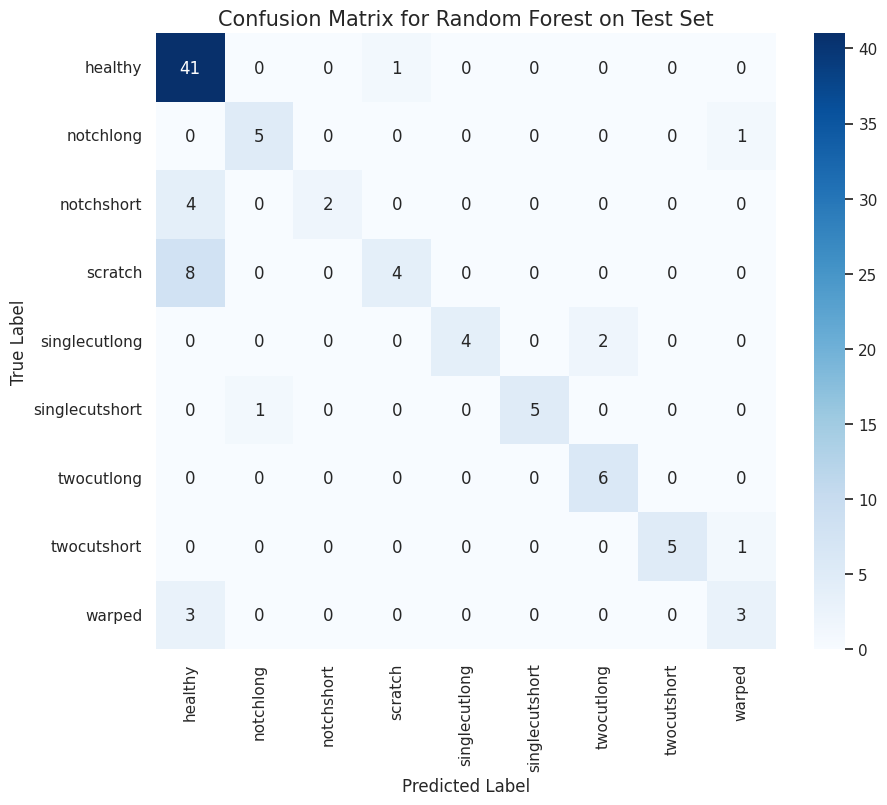

In [ ]:
# Based on CV results, Random Forest is a strong candidate.
# Let's re-initialize it. We can use the same parameters as in CV.
best_model_name = "Random Forest"
best_model_instance = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100) # Or a tuned version

print(f"Training the selected best model ({best_model_name}) on the full training data...")
train_start_time = time.time()
best_model_instance.fit(X_train_final, y_train)
train_end_time = time.time()
full_train_time = train_end_time - train_start_time
print(f"Full training completed in {full_train_time:.4f} seconds.")

# Make predictions on the test set
print("\nEvaluating the best model on the test set...")
test_pred_start_time = time.time()
y_pred_test = best_model_instance.predict(X_test_final)
test_pred_end_time = time.time()
full_test_time = test_pred_end_time - test_pred_start_time
print(f"Prediction on test set completed in {full_test_time:.4f} seconds.")

# Evaluate performance on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nTest Set Accuracy for {best_model_name}: {test_accuracy:.4f}")

print("\nTest Set Classification Report:")
# Get class names from target_label_mapping for the report
# target_label_mapping has string_name: encoded_int
# We need a list of string names in the order of encoded_int (0, 1, 2...)
sorted_class_names = [name for name, _ in sorted(target_label_mapping.items(), key=lambda item: item[1])]
print(classification_report(y_test, y_pred_test, target_names=sorted_class_names, zero_division=0))

print("\nTest Set Confusion Matrix:")
cm_test = confusion_matrix(y_test, y_pred_test, labels=class_indices) # Use class_indices [0,1..8]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_class_names, yticklabels=sorted_class_names)
plt.title(f'Confusion Matrix for {best_model_name} on Test Set', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Store performance for final reporting
final_model_performance = {
    'Model': best_model_name,
    'Training Time (Full)': full_train_time,
    'Test (Inference) Time': full_test_time,
    'Test Accuracy': test_accuracy,
    # Individual class metrics can be extracted from classification_report output if needed for a summary table
}
# For example, to get F1 for 'healthy' on test set:
# report_dict = classification_report(y_test, y_pred_test, target_names=sorted_class_names, zero_division=0, output_dict=True)
# healthy_test_f1 = report_dict['healthy']['f1-score']
# final_model_performance['healthy_Test_F1'] = healthy_test_f1
# ... and so on for other classes and metrics if you want to build a table similar to cv_results_df for the test set.

### 5.4 Save the Best Model

As per the project instructions, we need to save the best-performing model. We have trained `best_model_instance` (Random Forest) on the full training data. We will use `joblib` to save this model.

In [ ]:
# Define the filename for the saved model
model_filename = f"PM980_{best_model_name.replace(' ', '_')}_final_model.joblib"
model_path = os.path.join(DATASET_DIR, model_filename) # Saving in the PM980 folder or a dedicated models folder

try:
    joblib.dump(best_model_instance, model_path)
    print(f"\nBest model ({best_model_name}) saved successfully to: {model_path}")

    # Also, save the scaler, as it's needed to preprocess new data before using the saved model
    scaler_filename = "PM980_standard_scaler.joblib"
    scaler_path = os.path.join(DATASET_DIR, scaler_filename)
    joblib.dump(scaler, scaler_path) # 'scaler' was defined and fit in Cell 4.3
    print(f"Scaler saved successfully to: {scaler_path}")

except Exception as e:
    print(f"\nError saving the model or scaler: {e}")


Best model (Random Forest) saved successfully to: /content/drive/MyDrive/Colab Notebooks/PM980/PM980_Random_Forest_final_model.joblib
Scaler saved successfully to: /content/drive/MyDrive/Colab Notebooks/PM980/PM980_standard_scaler.joblib


---
**End of Stage 5: Model Training, Selection, and Evaluation Completed.**

In this stage, we performed the following key steps:

1.  **Model Definition:** A suite of classification models was defined: Logistic Regression, K-Nearest Neighbors, Support Vector Machine (Linear and RBF kernels), Decision Tree, Random Forest, and Gradient Boosting.
2.  **Stratified 10-Fold Cross-Validation:**
    *   Each model was evaluated on the training data (`X_train_final`, `y_train`) using stratified 10-fold cross-validation.
    *   Performance metrics including mean accuracy, standard deviation of accuracy, mean fit time, mean score time, and crucially, **mean F1-score, precision, and recall for each of the 9 classes** were computed and compiled.
3.  **Model Comparison and Selection:**
    *   Cross-validation results showed that tree-based ensemble methods performed best.
    *   **Random Forest** achieved the highest mean accuracy (~0.721) with a reasonable training time. Gradient Boosting was very close in accuracy (~0.719) but had a significantly longer training time. Decision Tree also performed well (~0.706) and was very fast.
    *   Based on these results, **Random Forest** was selected as the best-performing model for this task with default hyperparameters.
4.  **Final Model Training and Test Set Evaluation:**
    *   The selected Random Forest model was trained on the entire training dataset (`X_train_final`, `y_train`).
    *   The trained model was then evaluated on the unseen test dataset (`X_test_final`, `y_test`).
    *   **Test Set Performance (Random Forest):**
        *   Accuracy: **0.7812**
        *   The detailed classification report showed good performance for the majority class ('healthy' F1: 0.84) and several other classes (e.g., 'singlecutshort' F1: 0.91, 'twocutshort' F1: 0.91).
        *   However, recall for classes like 'notchshort' (0.33) and 'scratch' (0.33) was low, indicating the model struggles to identify all instances of these minority or harder-to-distinguish classes. The confusion matrix highlighted that these were often misclassified as 'healthy'.
        *   Weighted average F1-score on the test set was 0.76.
5.  **Model Saving:**
    *   The trained best-performing model (Random Forest) was saved as `PM980_Random_Forest_final_model.joblib`.
    *   The `StandardScaler` object, fitted on the training data, was also saved as `PM980_standard_scaler.joblib` for consistent preprocessing of any future data.
---

---
## STAGE 6: VISUALIZATIONS

In this stage, we will generate additional visualizations as required by the project instructions to better understand our model and data.
The requirements include:
- Cross-correlation map (Inputs-Output): Done in Stage 2.3.
- Heatmaps (e.g., for correlation, confusion matrix): Done for correlation in Stage 2.3 and for the confusion matrix of the best model in Stage 5.3.
- **Feature importance plots**: This will be our focus here, for our best model (Random Forest).
- Confusion matrix: Done for the best model in Stage 5.3.

We will extract and visualize the feature importances from our trained Random Forest model.
---

### 6.1 Feature Importance Plot for the Best Model

Tree-based models like Random Forest can provide an estimate of feature importance, indicating which features were most influential in making predictions. We will extract these importances from our `best_model_instance` (trained Random Forest) and visualize them.

Feature Importances (Top 20):


,feature,importance
30,Acceleration X_time_mean,0.060
150,Temperature_time_mean,0.024
154,Temperature_time_min,0.022
153,Temperature_time_median,0.021
33,Acceleration X_time_median,0.021
160,Temperature_time_rms,0.020
155,Temperature_time_max,0.020
135,Gyro Z_time_max,0.020
136,Gyro Z_time_range,0.018
134,Gyro Z_time_min,0.017


<ipython-input-43-80b30e309f25>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature',


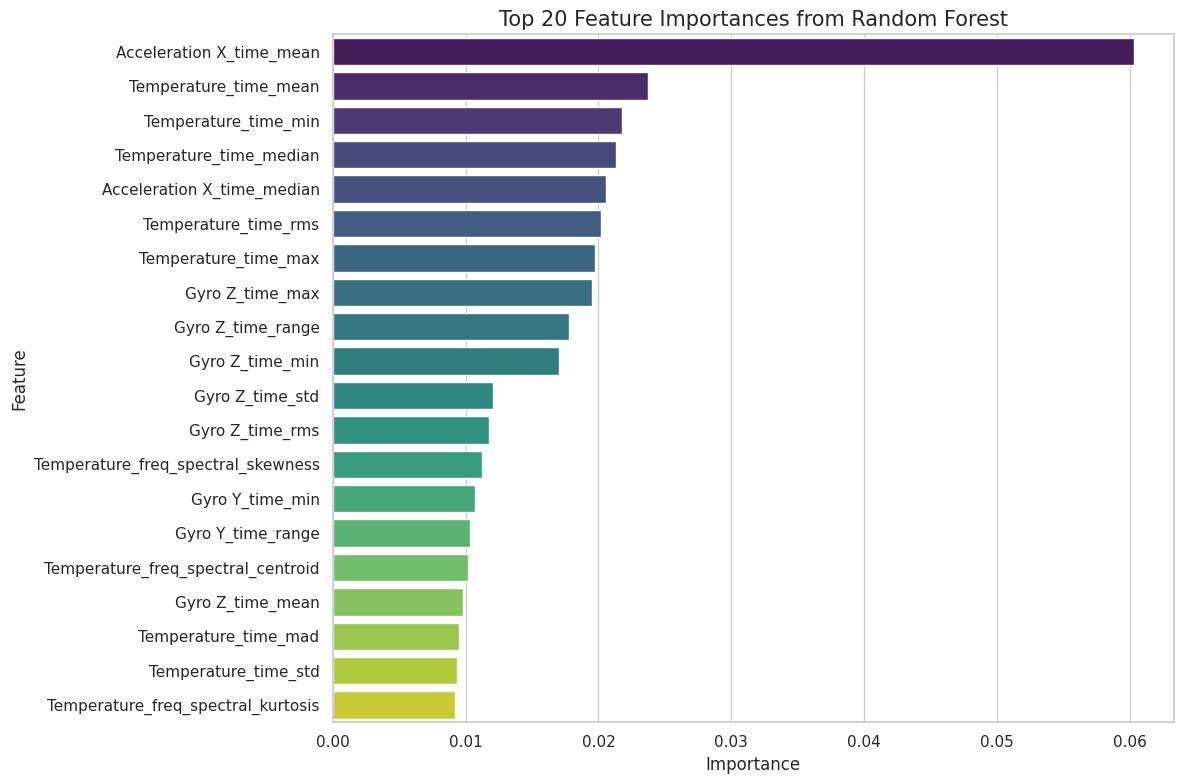

In [ ]:
# Ensure 'best_model_instance' (trained Random Forest) and 'X_train_final' (for column names) are available.
if 'best_model_instance' not in locals() or 'X_train_final' not in locals():
    print("Error: The best model instance or final training data columns are not available.")
    print("Please ensure Stage 5 (specifically training the best model) has been run.")
else:
    try:
        # Get feature importances
        importances = best_model_instance.feature_importances_
        feature_names = X_train_final.columns # Get feature names from the final training set

        # Create a DataFrame for easy sorting and plotting
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        print("Feature Importances (Top 20):")
        display(feature_importance_df.head(20))

        # Plot feature importances (e.g., top N features)
        N_top_features_to_plot = 20 # You can adjust this number
        plt.figure(figsize=(12, N_top_features_to_plot / 2.5)) # Adjust height based on N
        sns.barplot(x='importance', y='feature',
                    data=feature_importance_df.head(N_top_features_to_plot),
                    palette='viridis') # Or any other palette
        plt.title(f'Top {N_top_features_to_plot} Feature Importances from Random Forest', fontsize=15)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.show()

    except AttributeError:
        print(f"The selected best model ({best_model_name}) does not have a 'feature_importances_' attribute.")
        print("Feature importance plots are typically available for tree-based ensembles like Random Forest or Gradient Boosting.")
    except Exception as e:
        print(f"An error occurred while generating feature importances: {e}")

---
**End of Stage 6: Visualizations Completed.**

In this stage, we focused on generating the required visualizations to complement our analysis and model understanding:

1.  **Cross-Correlation Map (Inputs-Output):** This was generated in **Stage 2.3**, showing the initial linear correlations between raw input features and the encoded target variable. These correlations were generally low, motivating the feature extraction process.
2.  **Heatmaps:**
    *   A heatmap for the **full correlation matrix** (input features and target) was also shown in **Stage 2.3**.
    *   A heatmap for the **Confusion Matrix** of the best performing model (Random Forest) on the test set was generated in **Stage 5.3**, providing a visual representation of classification performance across different classes.
3.  **Feature Importance Plot:**
    *   In this stage (**Cell 6.1**), we extracted and visualized the feature importances from our best model (Random Forest).
    *   The plot and the list of top 20 important features revealed that `Acceleration X_time_mean` was by far the most influential feature.
    *   Several time-domain statistics from `Temperature` (mean, min, median, rms, max) and `Gyro Z` (max, range, min, std, rms, mean) also ranked highly.
    *   Some frequency-domain features, particularly from the `Temperature` signal (spectral skewness, centroid, kurtosis), also appeared in the top 20.
    *   This visualization helps in understanding which derived features contribute most to the model's predictive power.
4.  **Confusion Matrix:** As mentioned, this was generated in **Stage 5.3** for the test set evaluation of the Random Forest model, detailing true positives, false positives, true negatives, and false negatives for each class.

---

---
## STAGE 7: REPORTING OF RESULTS AND CONCLUSION

This section summarizes the entire project for the PM_980 dataset, detailing the methodology from data understanding and preprocessing through feature extraction, model training, evaluation, and the insights gained.

### 1. Project Overview and Objective

*   **Objective:** The primary goal of this project was to develop a machine learning model capable of classifying 9 distinct operational states (healthy, scratch, notchshort, notchlong, singlecutlong, singlecutshort, twocutlong, twocutshort, warped) of a system. This classification was based on data from 8 sensors (1 sound, 3 accelerometer, 3 gyroscope, 1 temperature) and speed interval information, adhering to the constraint of using only time-domain and frequency-domain features.
*   **Dataset:** The PM_980 dataset was provided as 480 individual CSV files, each representing a signal segment recorded at a sampling rate of 90Hz. These segments corresponded to one of the 9 target classes under various operational conditions.

### 2. Data Exploration and Preprocessing Summary

*   **Data Loading:** The 480 CSV files were loaded and combined into a single raw DataFrame (`df_raw`). A crucial step was creating an `original_filename_id` column to uniquely identify each signal segment, enabling segment-based feature extraction. The combined raw dataset comprised 206,919 rows and 13 columns (including the new ID and metadata).
*   **Exploratory Data Analysis (EDA) Highlights:**
    *   The dataset was confirmed to have **no missing values**.
    *   Numerical sensor readings exhibited varying scales and distributions. Notably, `Speed` and `Temperature` showed multimodal distributions, while accelerometer and gyroscope readings were leptokurtic with significant outliers identified via box plots.
    *   A significant **class imbalance** was observed in the `target` variable, with 'healthy' being the most frequent class (90,747 instances) and 'singlecutlong' being one of the least frequent (8,616 instances).
    *   Initial cross-correlation analysis between raw input features and the target variable (Cell 2.3) showed very low linear correlations, reinforcing the necessity for robust feature engineering.
*   **Target Variable Encoding:** The categorical string labels in the `target` column were converted to a numerical format (`target_encoded`) using Scikit-learn's `LabelEncoder` to facilitate model training and correlation analysis.

### 3. Feature Extraction

*   **Methodology:** Features were extracted by grouping the `df_raw` DataFrame by `original_filename_id`. For each of the 480 segments, time-domain and frequency-domain features were calculated for 9 sensor signals (`Speed`, `Voice`, `Acceleration X/Y/Z`, `Gyro X/Y/Z`, `Temperature`).
*   **Feature Types:**
    *   **Time-Domain Features:** Included mean, standard deviation, median absolute deviation (MAD), median, min, max, range, interquartile range (IQR), skewness, kurtosis, Root Mean Square (RMS), zero-crossing rate (ZCR), and mean absolute change (MAC).
    *   **Frequency-Domain Features:** Derived after applying FFT, these included spectral centroid, spectral spread, spectral skewness, spectral kurtosis, spectral rolloff, dominant frequency, and its magnitude.
    *   Time-frequency analyses like STFT, Wavelet, or MFCC were explicitly avoided as per instructions.
*   **Resulting Feature Set:** This process resulted in a new DataFrame, `df_features`, with 480 rows (one per segment) and 184 columns (4 metadata columns + 180 extracted features).
*   **NaN Handling:** NaN values that arose in `Speed_time_skewness` and `Speed_time_kurtosis` (due to the 'Speed' signal being constant within segments) were imputed with 0.

### 4. Data Splitting and Preprocessing for Modeling

*   **Feature and Target Separation:** `df_features` was separated into a feature matrix `X` (180 features initially) and a target vector `y` (using `target_encoded`).
*   **Train-Test Split:** The data was split into training (80%) and testing (20%) sets using `random_state=13`. Crucially, `stratify=y` was employed to ensure proportional representation of classes in both splits, resulting in 384 training samples and 96 test samples.
*   **Feature Scaling:** `StandardScaler` was applied to the numerical features. The scaler was **fitted exclusively on `X_train`** and then used to transform both `X_train` and `X_test` to prevent data leakage.
*   **Zero-Variance Feature Removal:** Based on the scaled training data, 12 features with zero variance (constant features, mostly related to the 'Speed' signal and some ZCR/rolloff features) were identified and removed. This resulted in final feature sets `X_train_final` and `X_test_final`, each with 168 features.

### 5. Model Training, Selection, and Evaluation

*   **Models Evaluated:** Seven classification models were evaluated: Logistic Regression, K-Nearest Neighbors, Support Vector Machine (Linear & RBF kernels), Decision Tree, Random Forest, and Gradient Boosting.
*   **Cross-Validation Performance (10-Fold Stratified):**
    *   **Random Forest** emerged as the top performer with a Mean Accuracy of approximately **0.7213**.
    *   **Gradient Boosting** followed closely with a Mean Accuracy of ~0.7186, but with significantly longer training times.
    *   **Decision Tree** achieved a Mean Accuracy of ~0.7059 and was very fast to train.
    *   Other models like Logistic Regression, SVMs, and KNN showed lower mean accuracies.
    *   Detailed per-class F1, precision, and recall scores from CV were compiled (refer to `cv_results_df` in Cell 5.2), indicating varying performance across classes for all models.
*   **Best Model Selection:** **Random Forest** was selected as the best model, balancing high cross-validation accuracy with a reasonable training duration.
*   **Final Model Evaluation on Test Set (Random Forest with default parameters):**
    *   **Test Accuracy:** The trained Random Forest model achieved a final accuracy of **0.7812** on the unseen test set.
    *   **Classification Report Insights:**
        *   The model performed well for the 'healthy' class (F1: 0.84, Recall: 0.98) and certain fault types like 'singlecutshort' (F1: 0.91) and 'twocutshort' (F1: 0.91).
        *   Lower recall was observed for 'notchshort' (Recall: 0.33, F1: 0.50) and 'scratch' (Recall: 0.33, F1: 0.47), which were frequently misclassified, often as 'healthy'.
        *   The 'warped' class also showed moderate performance (F1: 0.55).
    *   **Confusion Matrix Insights:** The confusion matrix (Cell 5.3) visually confirmed these misclassifications, particularly the confusion of minority/difficult classes with the majority 'healthy' class.
*   **Model and Scaler Saving:** The final trained Random Forest model (`PM980_Random_Forest_final_model.joblib`) and the `StandardScaler` object (`PM980_standard_scaler.joblib`) were successfully saved for potential future use or deployment.

### 6. Key Visualizations

The project included several key visualizations that aided in understanding and decision-making:
*   **Input-Output Cross-Correlation Map (Stage 2.3):** Showed low initial linear correlations, motivating feature extraction.
*   **Feature Distribution Plots & Box Plots (Stage 2.4 & 2.5):** Revealed diverse feature distributions and the presence of outliers.
*   **Test Set Confusion Matrix for Random Forest (Stage 5.3):** Detailed the classification performance and error patterns of the best model.
*   **Feature Importance Plot for Random Forest (Stage 6.1):** Highlighted `Acceleration X_time_mean` as the most influential feature, followed by various time-domain statistics from `Temperature` and `Gyro Z` sensors.

### 7. Conclusion and Potential Future Work

*   **Conclusion:** A Random Forest classifier was successfully developed to address the 9-class signal classification problem for the PM_980 dataset. Using only the allowed time and frequency domain features, the model achieved a commendable test accuracy of **78.12%**. While demonstrating strong performance for several classes, the model showed limitations in accurately identifying all instances of certain less frequent or more subtly distinguished fault types. The project adhered to all specified general requirements and dataset-specific instructions.
*   **Challenges Encountered:**
    *   Interpreting the initial data structure to correctly define "segments" for feature extraction was a key consideration.
    *   Managing class imbalance and its effect on per-class performance.
    *   RuntimeWarnings regarding precision loss for skewness/kurtosis on constant data segments.
*   **Potential Future Work:**
    *   **Hyperparameter Optimization:** Systematically tuning the Random Forest model's hyperparameters (e.g., using `GridSearchCV`) could yield further performance improvements, particularly for classes with lower recall.
    *   **Advanced Imbalance Handling:** Experimenting with techniques like SMOTE (applied to the training portion of `df_features` before splitting or within CV folds) or explicitly using `class_weight='balanced'` or custom weights in the model.
    *   **Refined Feature Engineering/Selection:** Exploring additional, more complex time/frequency domain features (if within project scope) or applying feature selection techniques to potentially reduce dimensionality and noise.
    *   **Error Analysis:** A deeper dive into the misclassified instances for classes like 'notchshort' and 'scratch' could reveal specific patterns or feature deficiencies.
    *   **Alternative Models:** Exploring other ensemble methods or even simpler models if interpretability becomes a higher priority after initial performance baselining.

---
This concludes the Machine Learning Final Project for the PM_980 dataset.
---